# Setup

In [1]:
setwd("/project/kohl_analysis/analysis/CAdir/results/results/")
renv::load("/project/kohl_analysis/analysis/CAdir")
devtools::load_all("/home/kohl/PhD/gits/ClemensKohl/CAdir")
source("./utils.R")

suppressPackageStartupMessages({
  library(APL)
  library(SingleCellExperiment)
  library(dplyr)
  library(tidyr)

  # To load the data set
  library(TENxPBMCData)
  library(Seurat)
  library(SeuratObject)
  library(scater)
  library(scuttle)
  library(scran)

  # Plotting
  library(ggsankey)
  # devtools::install_github("teunbrand/gguidance")
  library(gguidance)
  library(patchwork)
})

dir <- "/project/kohl_analysis/analysis/CAdir/results/results/"
imgdir <- file.path(dir, "img/figure2/")
dir.create(imgdir, recursive = TRUE)

options(repr.plot.width = 20, repr.plot.height = 15)

The following package(s) are missing entries in the cache:
- quarto
These packages will need to be reinstalled.

The following package(s) have broken symlinks into the cache:
- quarto
Use `renv::repair()` to try and reinstall these packages.

- The project is out-of-sync -- use `renv::status()` for details.


ℹ Loading CAdir






Warning message in dir.create(imgdir, recursive = TRUE):
“'/project/kohl_analysis/analysis/CAdir/results/results//img/figure2' already exists”


## Load data

In [2]:
sce <- sce_pbmc3k()

see ?TENxPBMCData and browseVignettes('TENxPBMCData') for documentation

loading from cache

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


# CAdir

In [3]:
set.seed(1234)

sce_bu <- sce
sce.dec <- scran::modelGeneVar(sce)
sce.top <- scran::getTopHVGs(sce.dec, prop = 0.2, var.threshold = NULL)
sce <- sce[sce.top, ]
sce <- runUMAP(sce, ntop = 2000)

ca <- cacomp(
    obj = as.matrix(logcounts(sce)),
    princ_coords = 3,
    dims = 30,
    top = nrow(sce),
    residuals = "pearson",
    python = TRUE,
    clip = TRUE
)

With `cutoff = NULL` CAdir tries to estimate the angle cutoff directly from the data.

## Split & Merge Clustering

In [4]:
set.seed(2358)
cak <- dirclust_splitmerge(
    caobj = ca,
    k = 12,
    cutoff = NULL,
    method = "random",
    apl_quant = 0.99,
    counts = NULL,
    min_cells = 30,
    reps = 5,
    make_plots = TRUE,
    apl_cutoff_reps = 100,
    qcutoff = 0.6 # 0.1
)

cak <- rank_genes(cadir = cak, caobj = ca)
top <- top_genes(cak)


Inferred cutoff angle: 65.41

Iteration 1
	Merging cluster_3 with cluster_6
• 	Merging cluster_3 with cluster_8
	Merging cluster_4 with cluster_8
• 	Merging cluster_4 with cluster_9
	Merging cluster_6 with cluster_7
• 	Merging cluster_6 with cluster_8
Iteration 2
Iteration 3
Iteration 4
Iteration 5


### Annotate clusters

caclust object with 2638 cells and 1097 genes.
6 clusters found.
Clustering results:

 cluster             ncells ngenes
 Megakaryocyte         21   123   
 Monocyte             667   178   
 Natural_killer_cell  399   199   
 B_cell               347   259   
 cluster_5             20   176   
 Naive_CD4+_T_cell   1184   162   

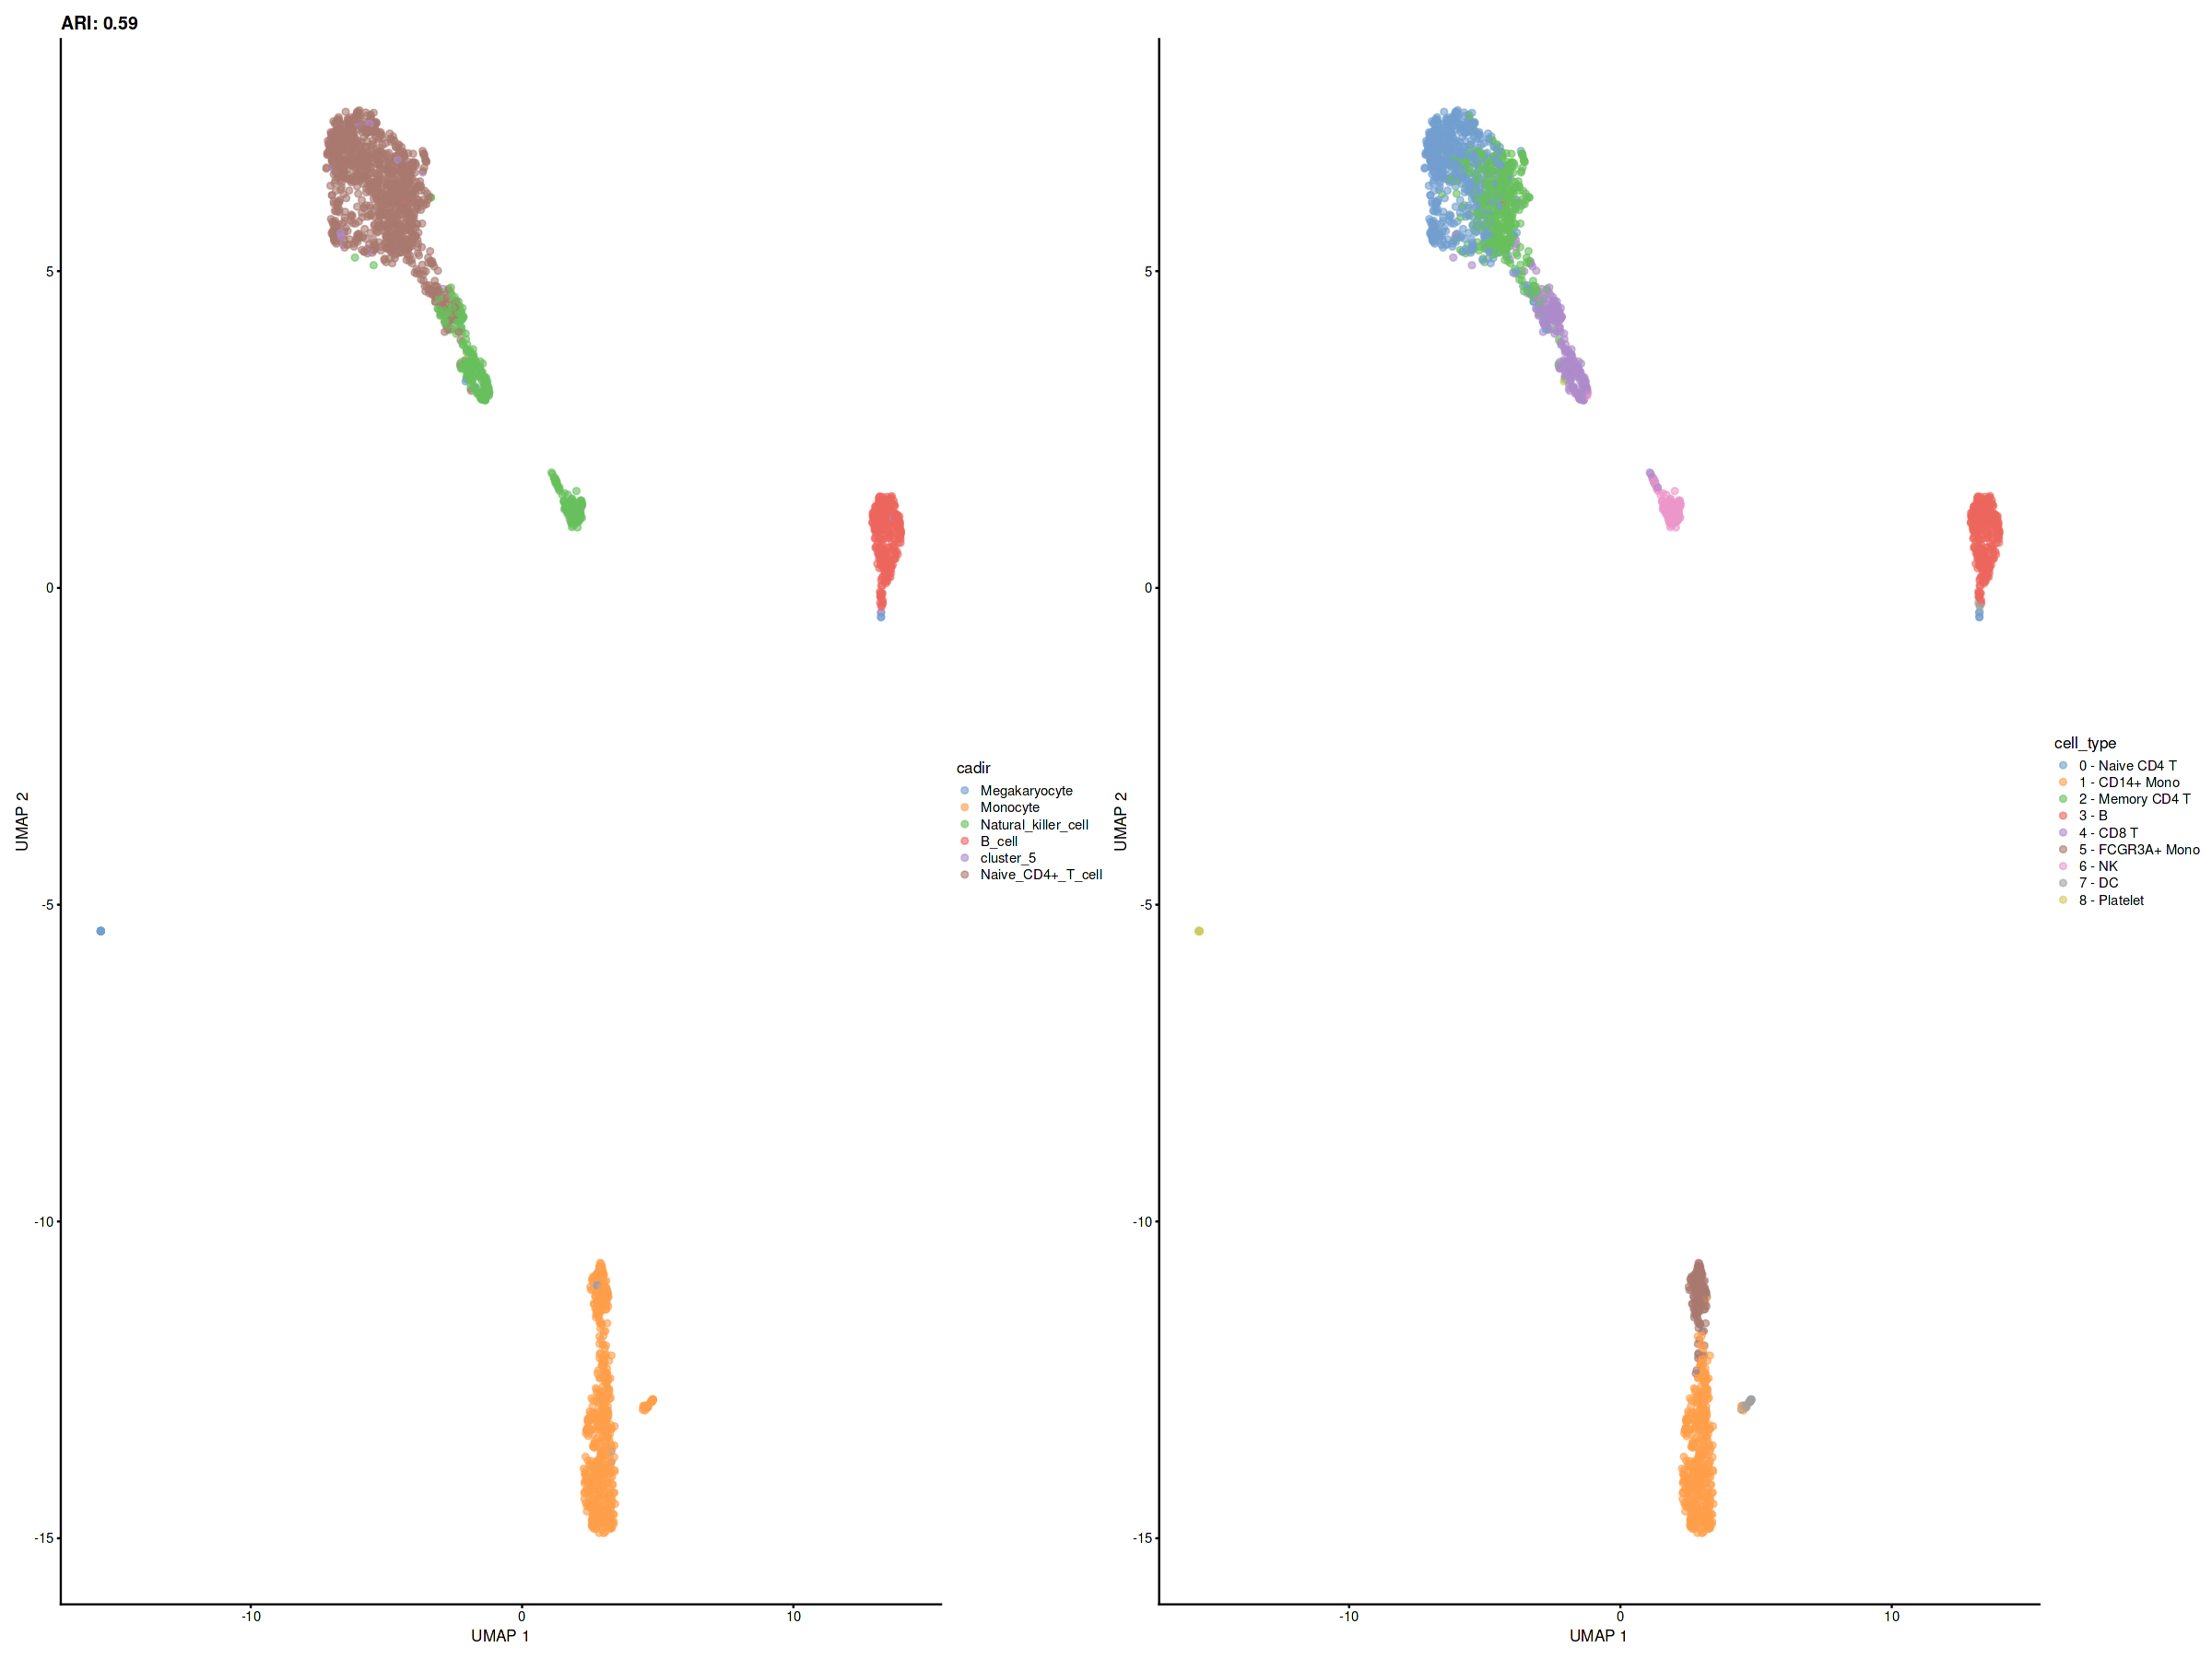

In [5]:
cak <- annotate_biclustering(
    obj = cak,
    universe = rownames(sce),
    org = "hs"
)

cak <- rank_genes(cadir = cak, caobj = ca)
cak

sce$cadir <- cak@cell_clusters

um1 <- plotUMAP(sce, colour = "cadir")
um2 <- plotUMAP(sce, colour = "cell_type")

ari <- aricode::clustComp(sce$cadir, sce$cell_type)
p <- um1 + ggtitle(paste0("ARI: ", round(ari$ARI, 2))) + um2
p

ggsave(
  plot = p,
  file = file.path(imgdir, "umap.png"),
  width = 3600,
  height = 1800,
  units = "px"
)

## Association plots of clusters

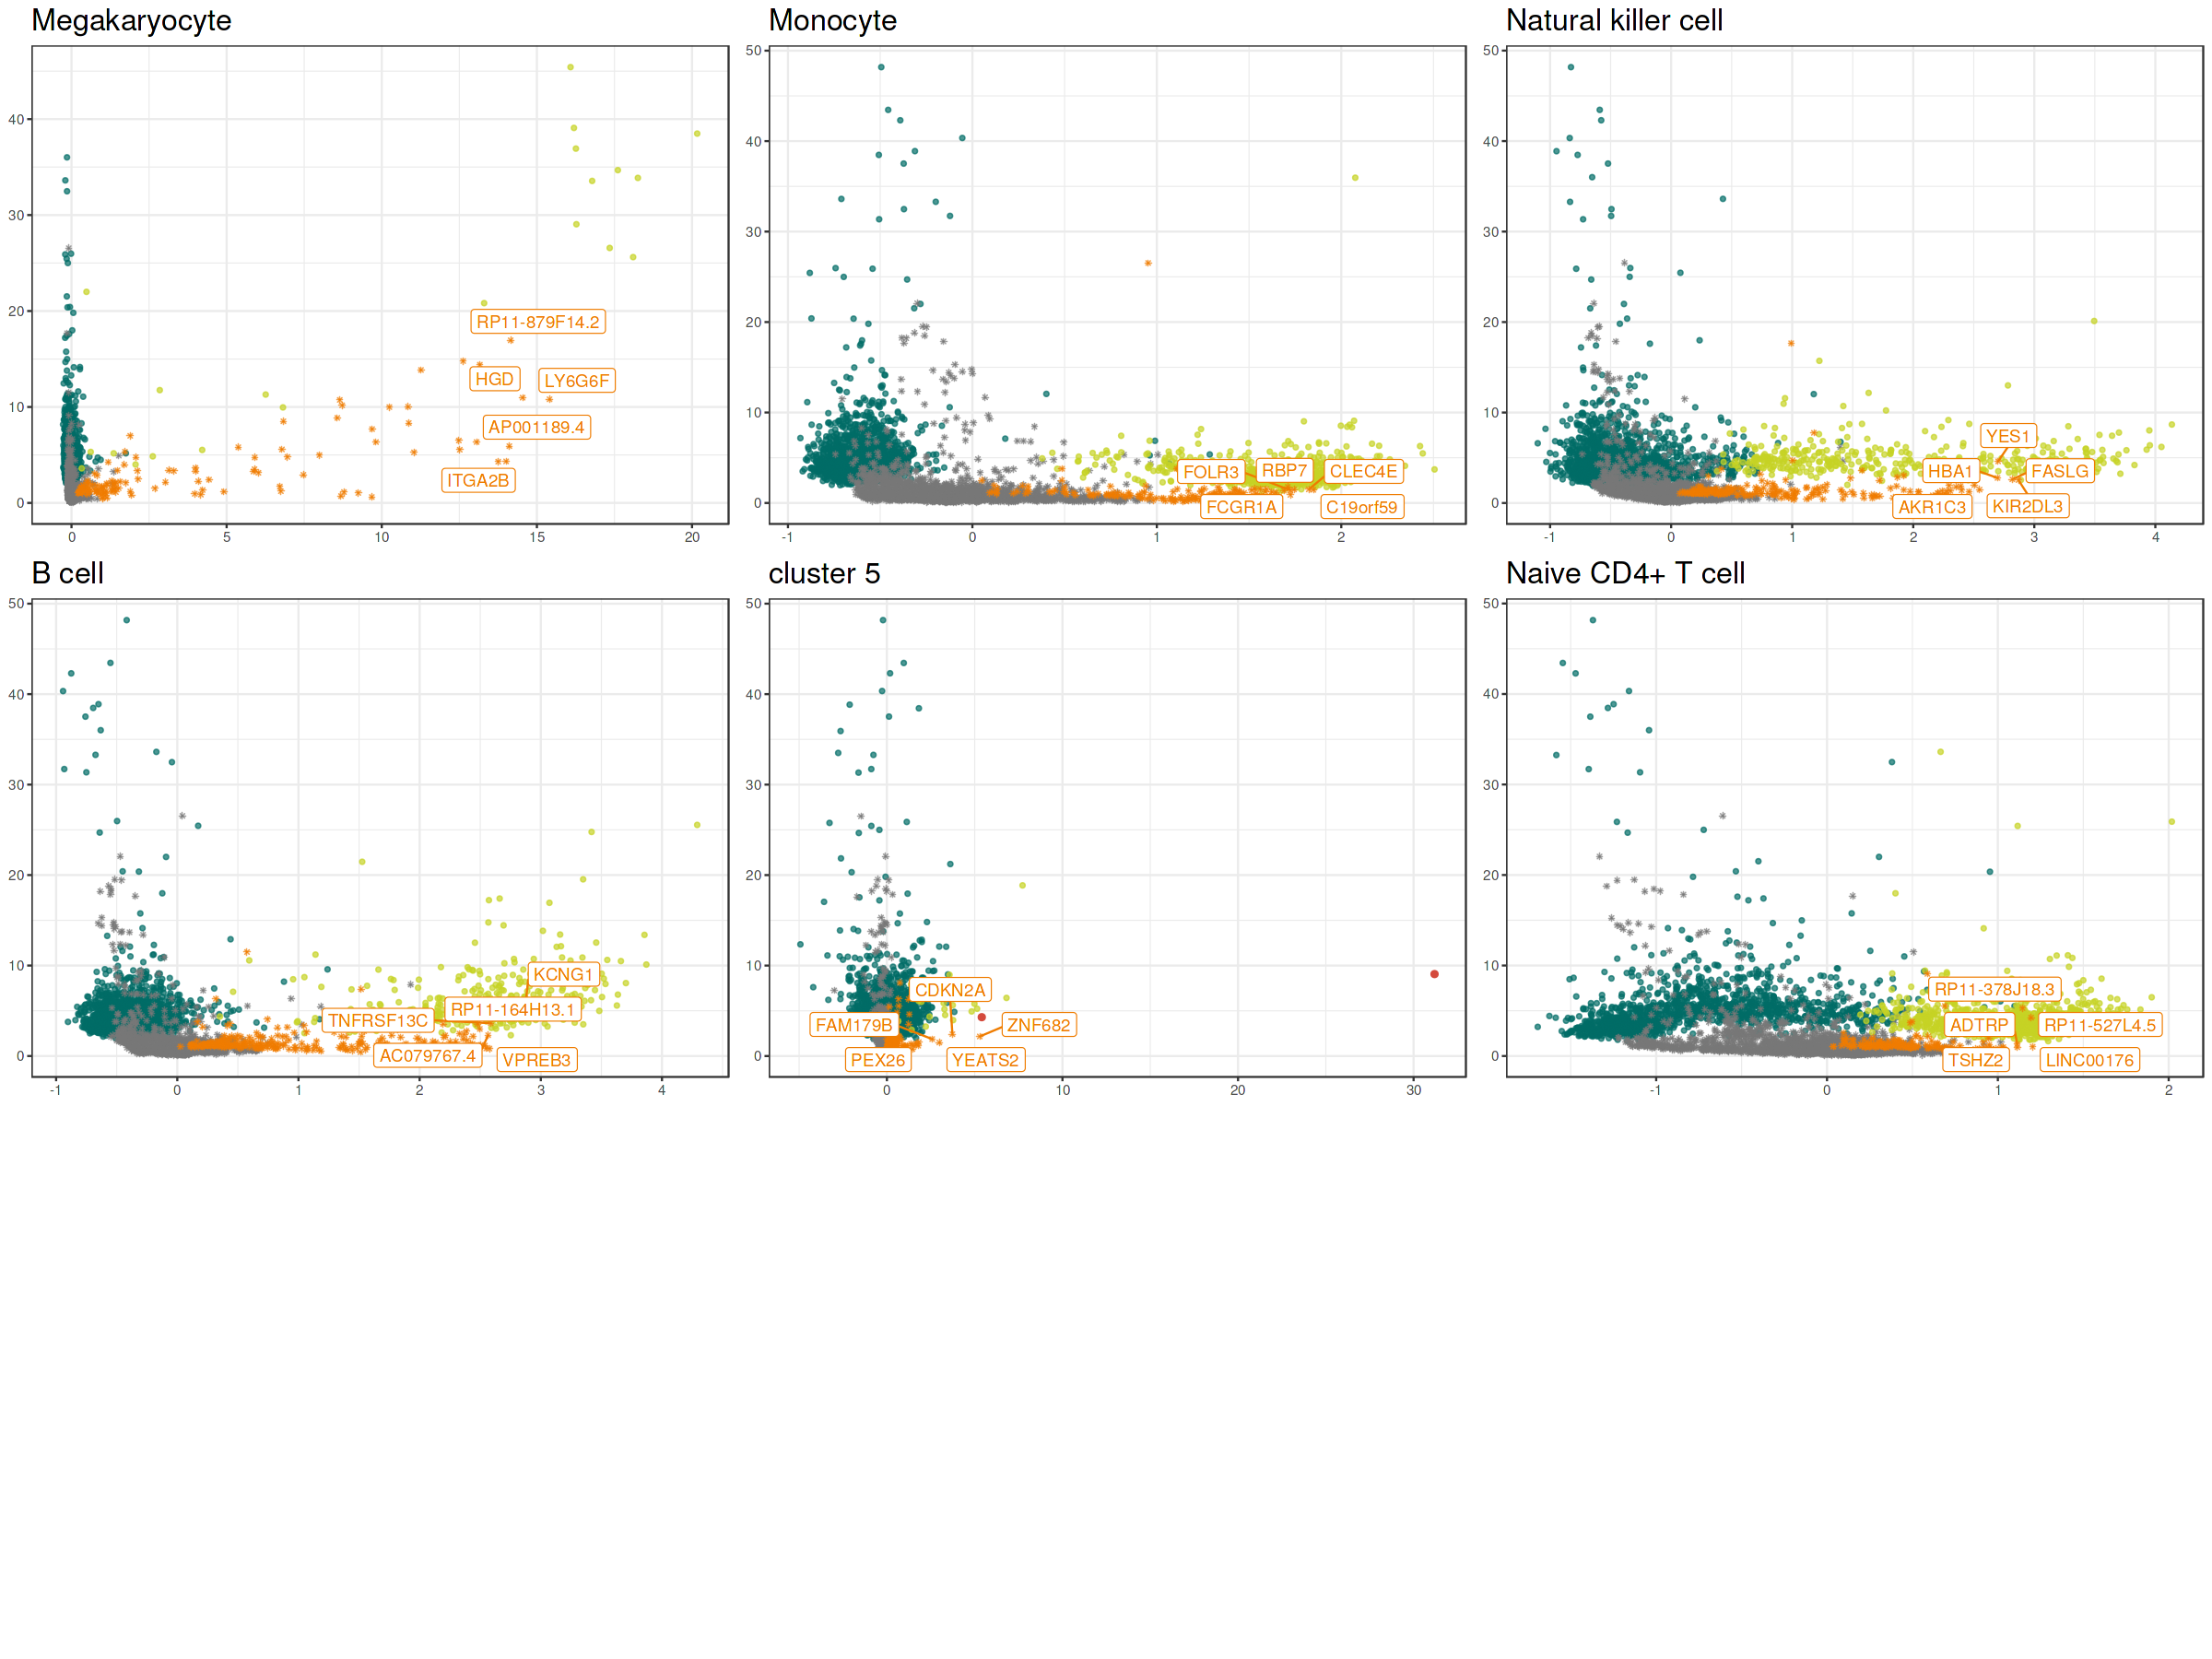

In [6]:
pc_mod <- plot_clusters_custom(
  cak,
  ca,
  show_genes = T,
  label_genes = T,
  ntop = 5,
  axis = TRUE,
  title_prefix = "",
  gsub_title = "_",
  outlier_cluster = "cluster_5",
  text_size = 19
)

pc_mod
ggsave(
  plot = pc_mod,
  file = file.path(imgdir, "plot_clusters.pdf"),
  width = 3400,
  height = 2000,
  units ="px"
)

ggsave(
  plot = pc_mod,
  file = file.path(imgdir, "plot_clusters.png"),
  width = 3400,
  height = 2000,
  units ="px"
)

### Identify outlier genes & cells

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


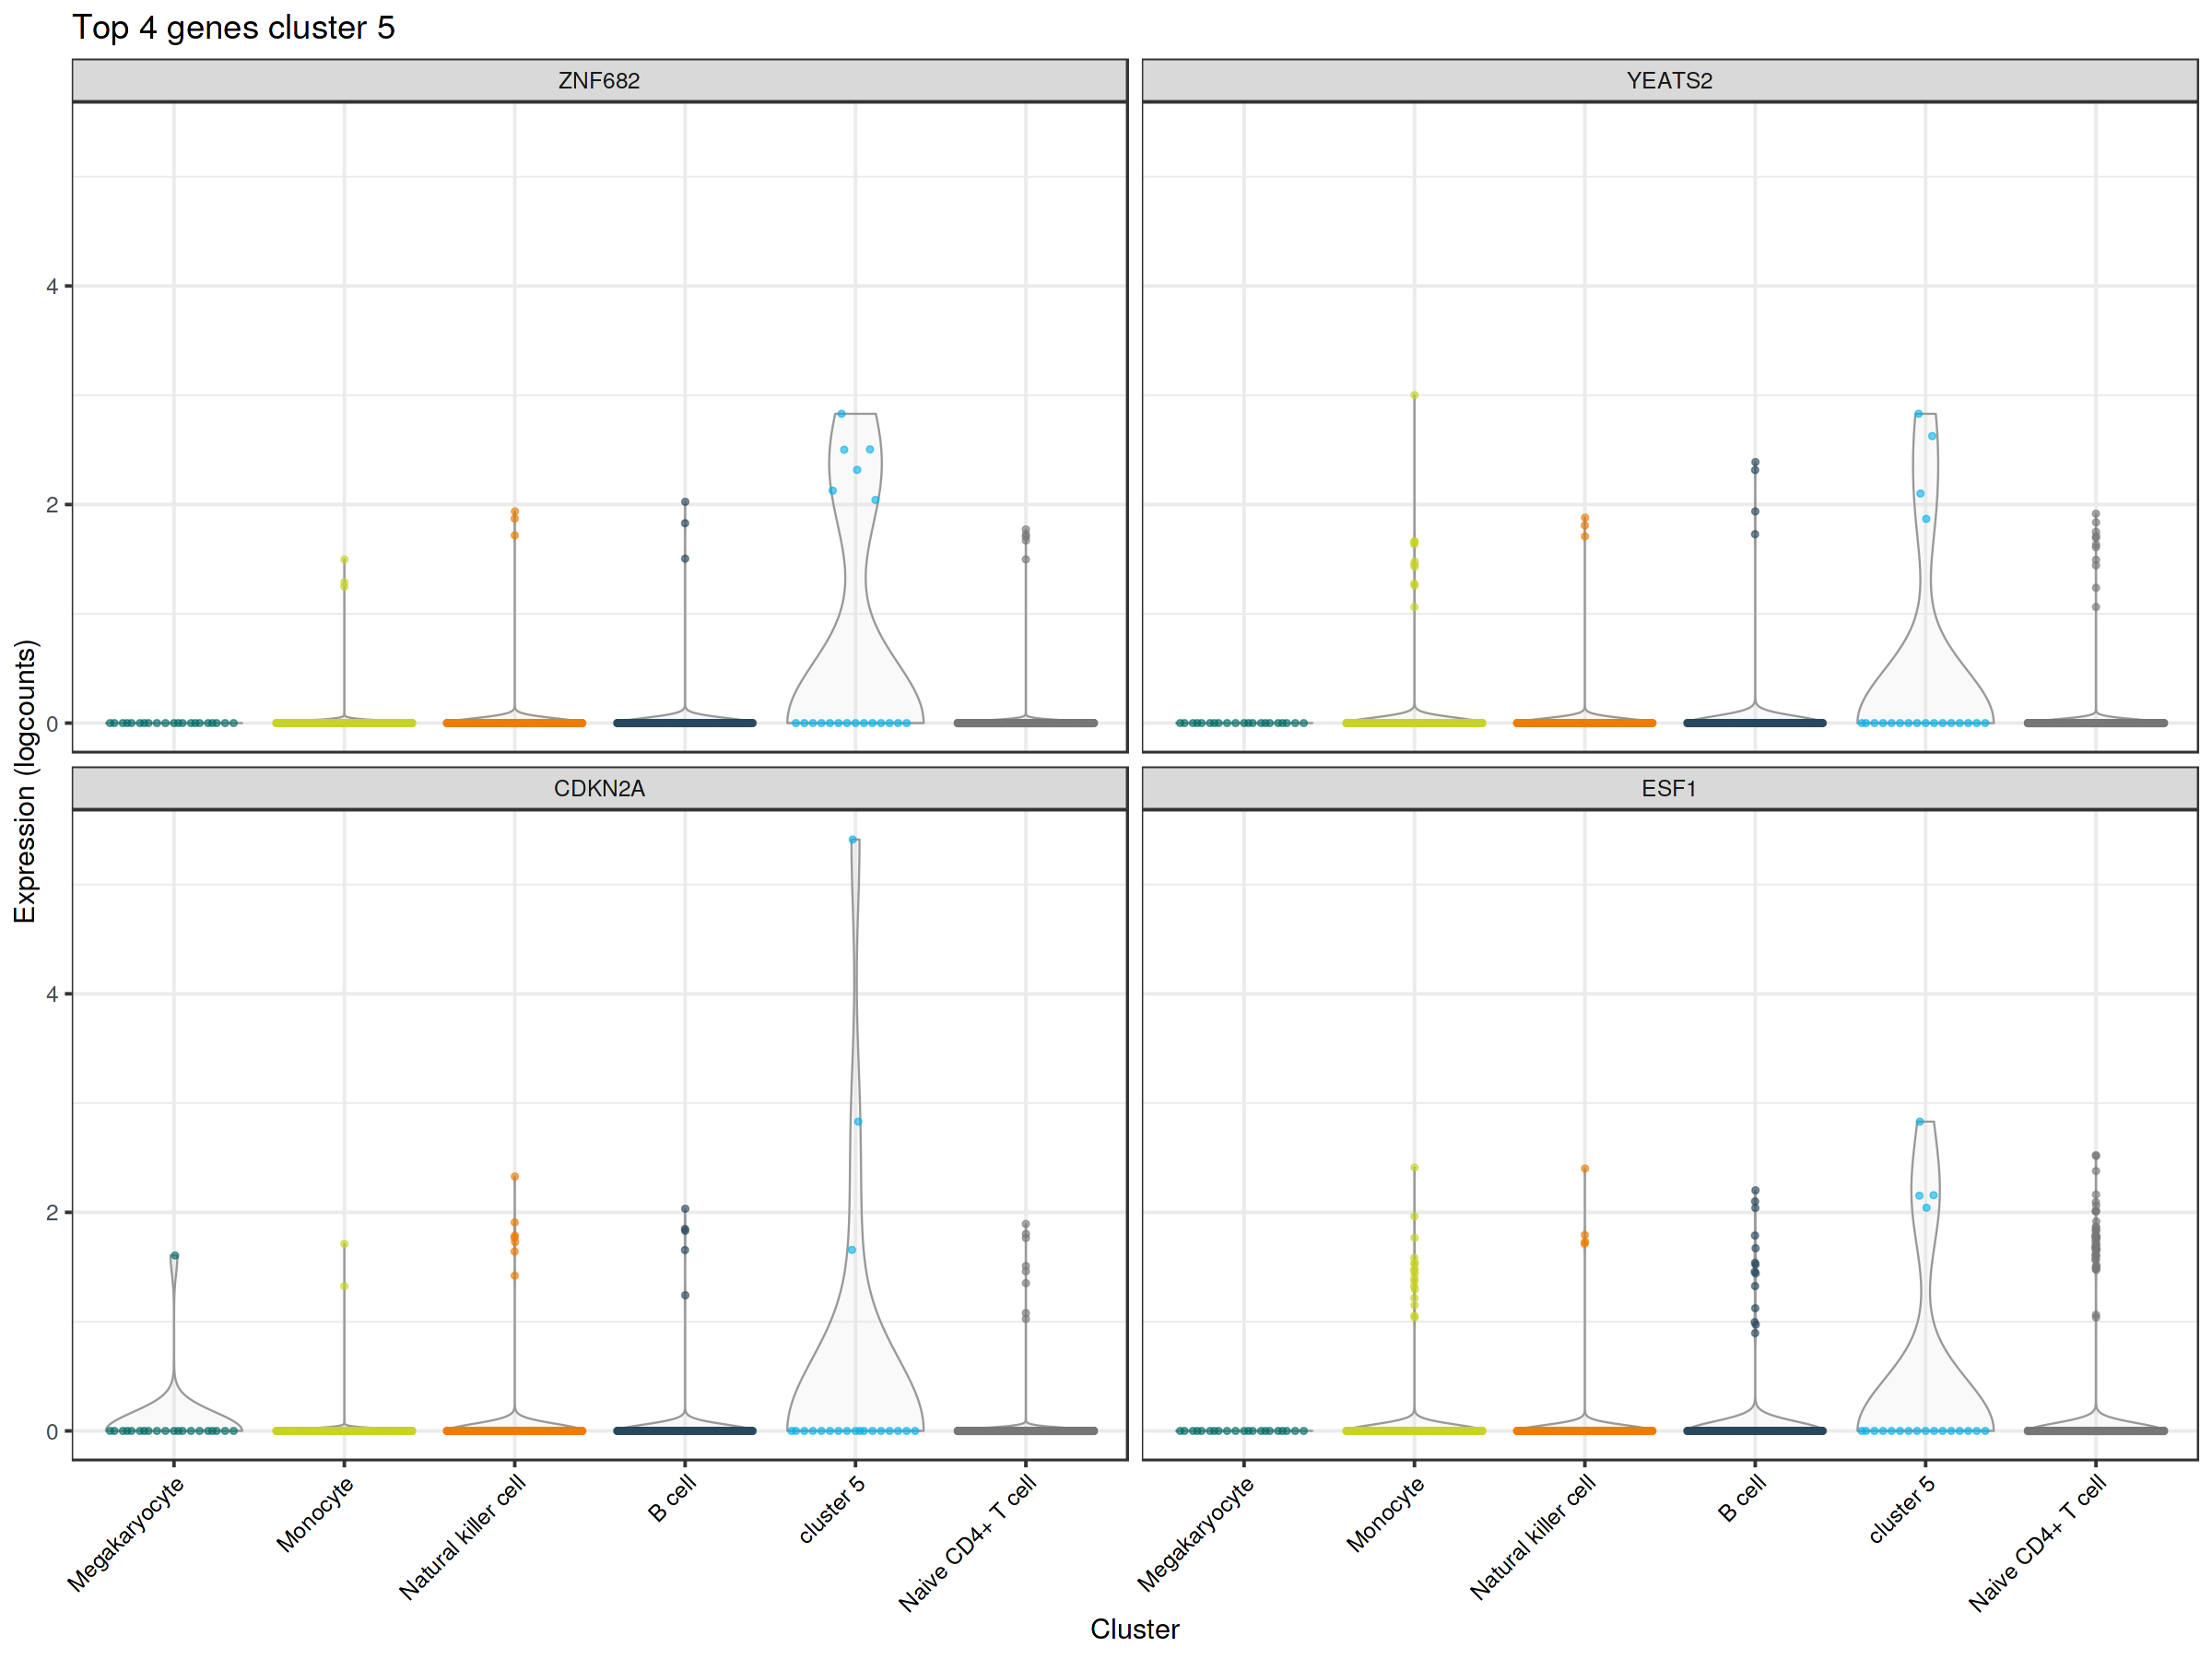

In [7]:
cak <- rank_genes(cak, ca)
rnks <- cak@gene_ranks$cluster_5
sce$cadir_mod <- gsub("_", " ", sce$cadir)
lvls <- gsub("_", " ", rownames(cak@directions))
sce$cadir_mod <- factor(sce$cadir_mod, levels = lvls)
p_expr <- scater::plotExpression(sce, features = head(rnks$Rowname, 4), x = "cadir_mod", colour_by = "cadir_mod", ncol = 2) +
  scale_color_mpimg() +
  labs(x = "Cluster", title = "Top 4 genes cluster 5") +
  theme_bw(base_size = 18) +
  theme(
  axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
  legend.position = "none"
 )

p_expr

ggsave(
  plot = p_expr,
  file = file.path(imgdir, "cluster_5_top_genes.pdf"),
  width = 2200,
  height = 2000,
  units = "px"
)

#### Correct outliers

In [8]:
cell_rnk <- get_top_cells(cadir = cak, caobj = ca, cluster = "cluster_5")
top_cells <- cell_rnk$Colname[cell_rnk$Score >= 0]
head(cell_rnk)

rnks <- cak@gene_ranks$cluster_5
top_genes <- unique(rnks$Rowname[rnks$Score >= 0])

,Colname,x,y,Score,Col_num,Cluster,Rank
,<chr>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>
TTAGAATGTGTAGC-1,TTAGAATGTGTAGC-1,31.193178,9.058663,20.8516078,19,cluster_5,1
CGACTCACGTTGCA-1,CGACTCACGTTGCA-1,5.403566,4.295152,0.5001257,11,cluster_5,2
TCCTAAACATCGAC-1,TCCTAAACATCGAC-1,6.811425,6.425992,-0.5246301,17,cluster_5,3
CCTGGACTCGTGAT-1,CCTGGACTCGTGAT-1,3.771604,3.968837,-0.7593086,10,cluster_5,4
AAGTCTCTCGGAGA-1,AAGTCTCTCGGAGA-1,4.827792,4.931051,-0.8016049,4,cluster_5,5
AGTGTTCTATAAGG-1,AGTGTTCTATAAGG-1,5.137080,5.229147,-0.8326308,8,cluster_5,6


Cells that are strongly associated to the cluster:

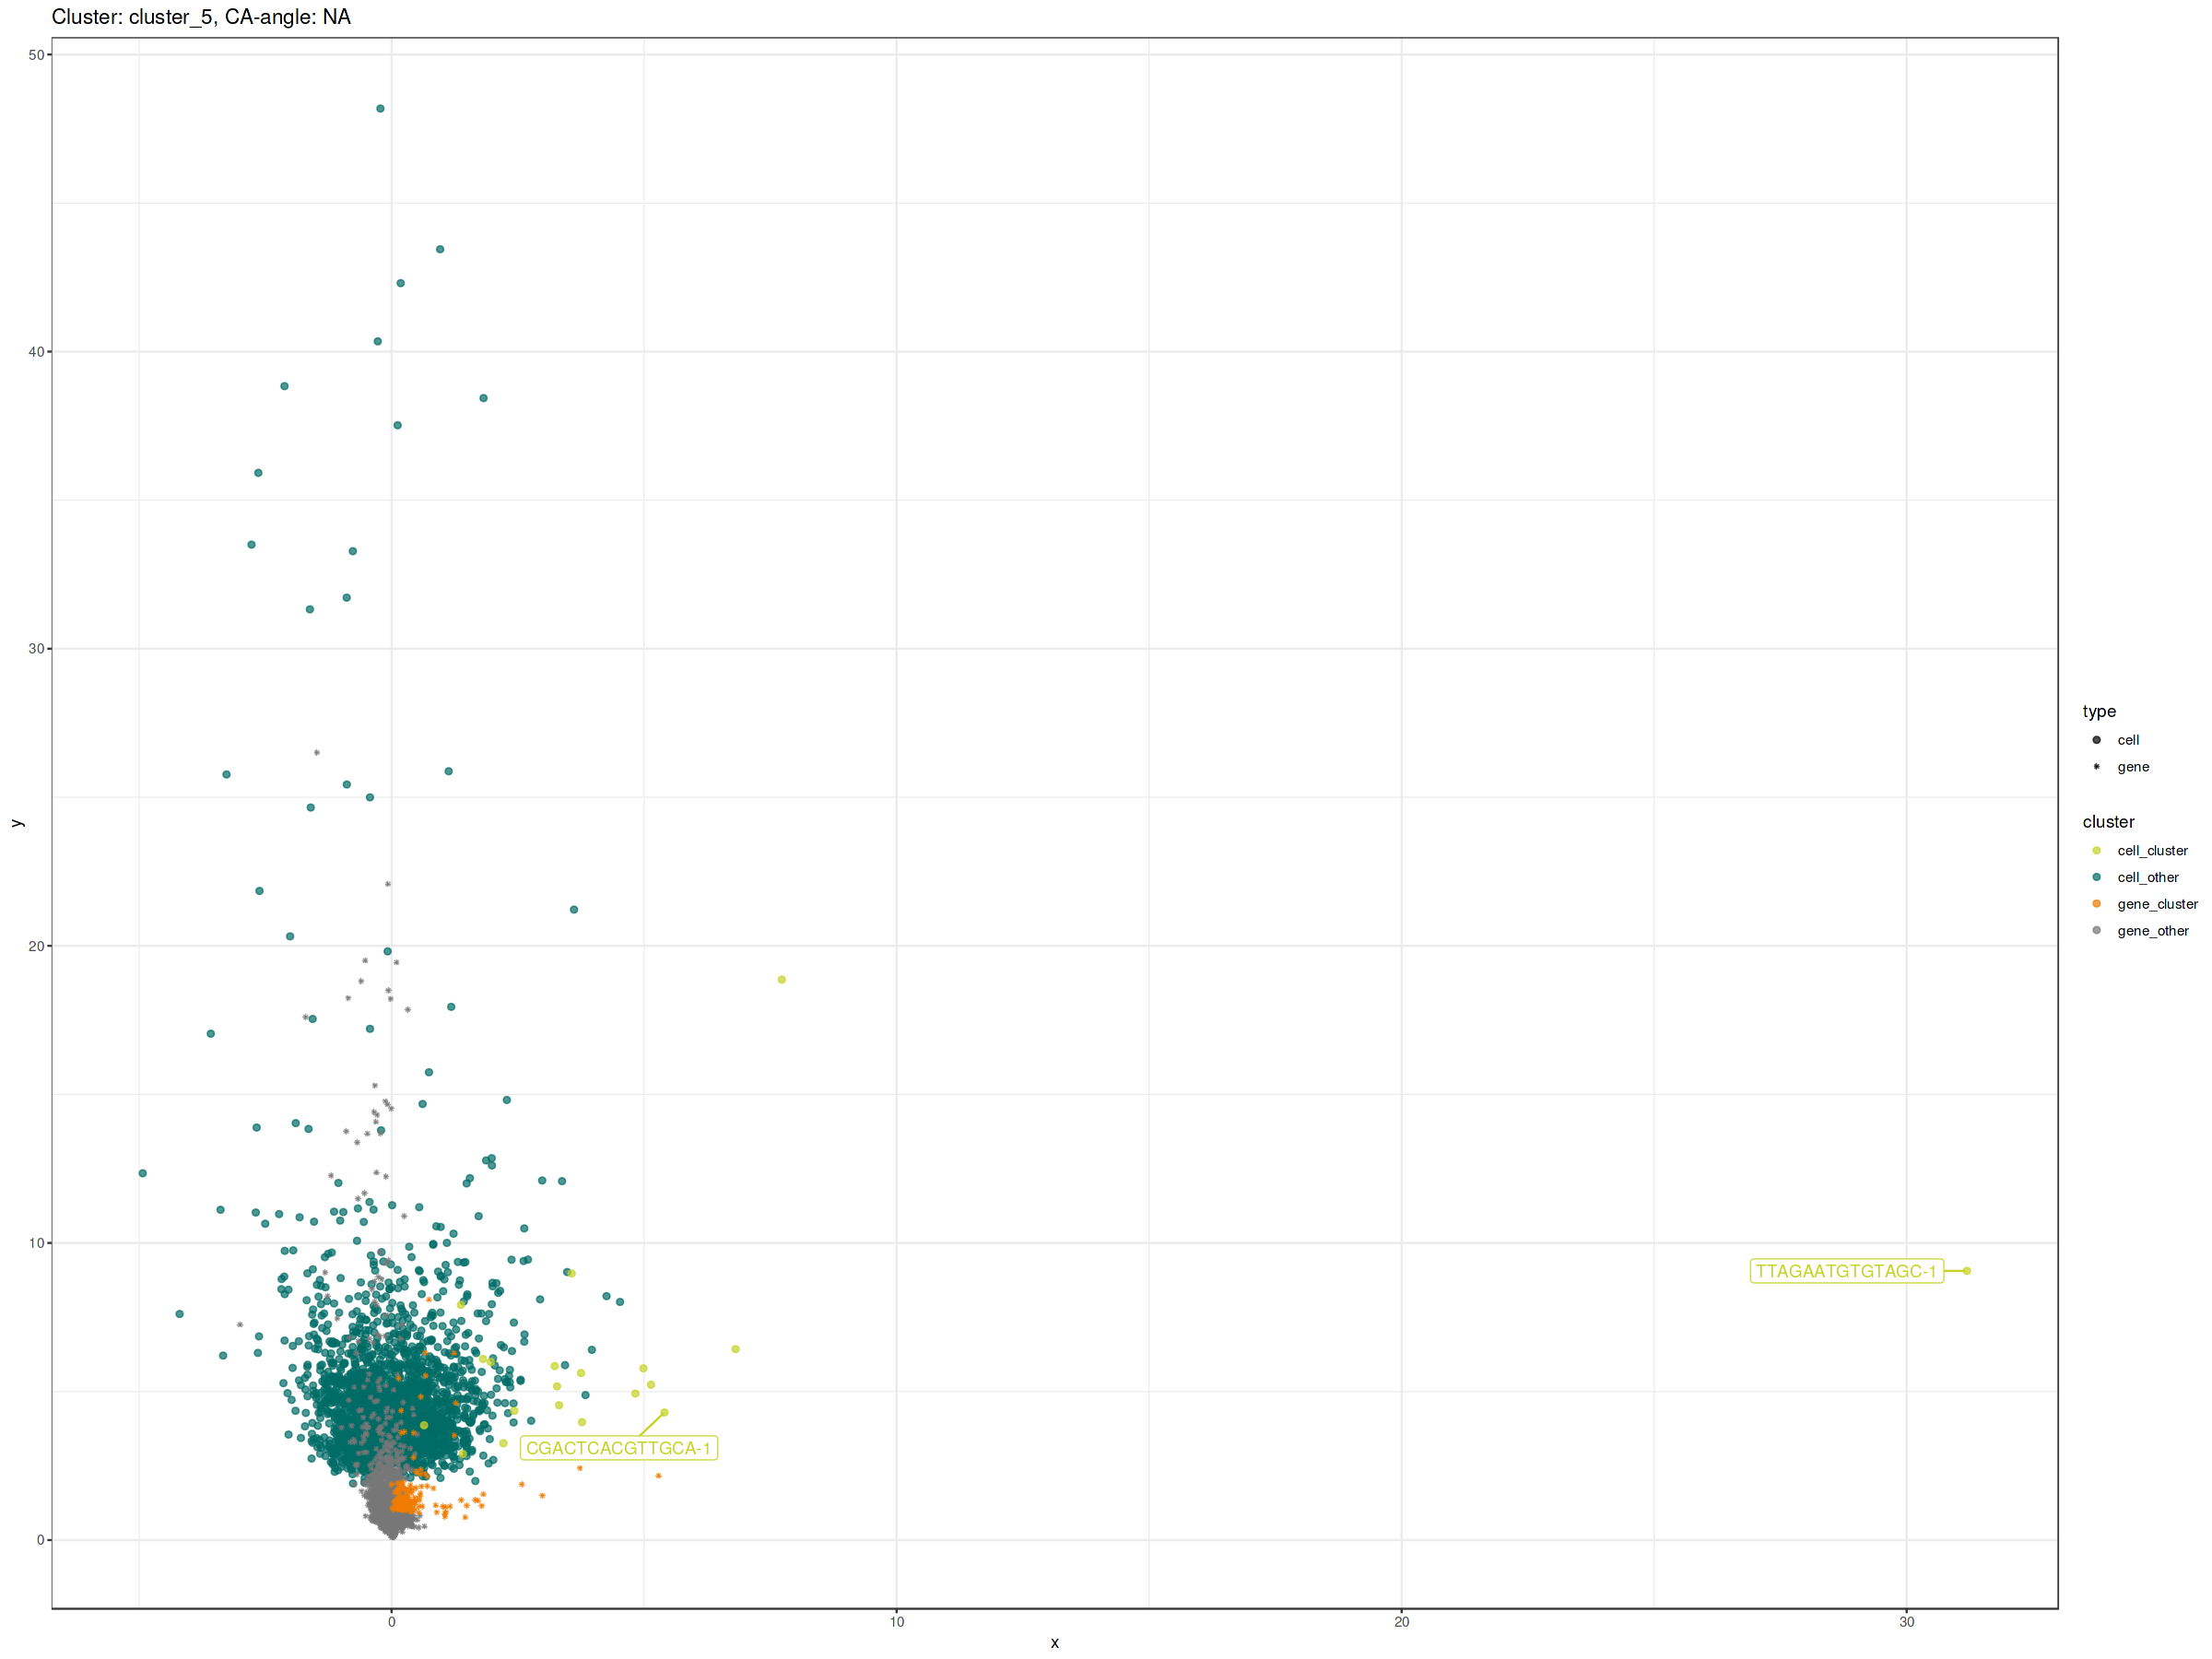

In [9]:
p_cl5_cells <- cluster_apl(
  ca,
  cak,
  cluster = "cluster_5",
  direction = cak@directions["cluster_5", ],
  group = which(cak@cell_clusters == "cluster_5"),
  highlight_cluster = TRUE,
  show_genes = TRUE,
  label_genes = FALSE,
  show_lines = FALSE,
  size_factor = 0.5,
  ntop = 5
  ) +
ggrepel::geom_label_repel(
    data = cell_rnk[cell_rnk$Score >= 0,],
  ggplot2::aes(
    x = x,
    y = y,
    label = Colname
  ),
  color = "#c6d325",
  box.padding = 1,
  max.overlaps = Inf
)

p_cl5_cells
ggsave(
  plot = p_cl5_cells,
  file = file.path(imgdir, "cluster_5_cells.pdf"),
  width = 1600,
  height = 1600,
  units = "px"
)

Remove outliers:


Inferred cutoff angle: 64.87

Iteration 1
	Merging cluster_2 with cluster_7
• 	Merging cluster_2 with cluster_8
	Merging cluster_3 with cluster_7
• 	Merging cluster_3 with cluster_10
	Merging cluster_4 with cluster_5
• 	Merging cluster_4 with cluster_7
Iteration 2
	Merging cluster_3 with cluster_6
Iteration 3
Iteration 4
Iteration 5


caclust object with 2636 cells and 1092 genes.
5 clusters found.
Clustering results:

 cluster             ncells ngenes
 Megakaryocyte         22   131   
 Naive_CD4+_T_cell   1197   210   
 Natural_killer_cell  402   239   
 B_cell               348   317   
 Monocyte             667   195   

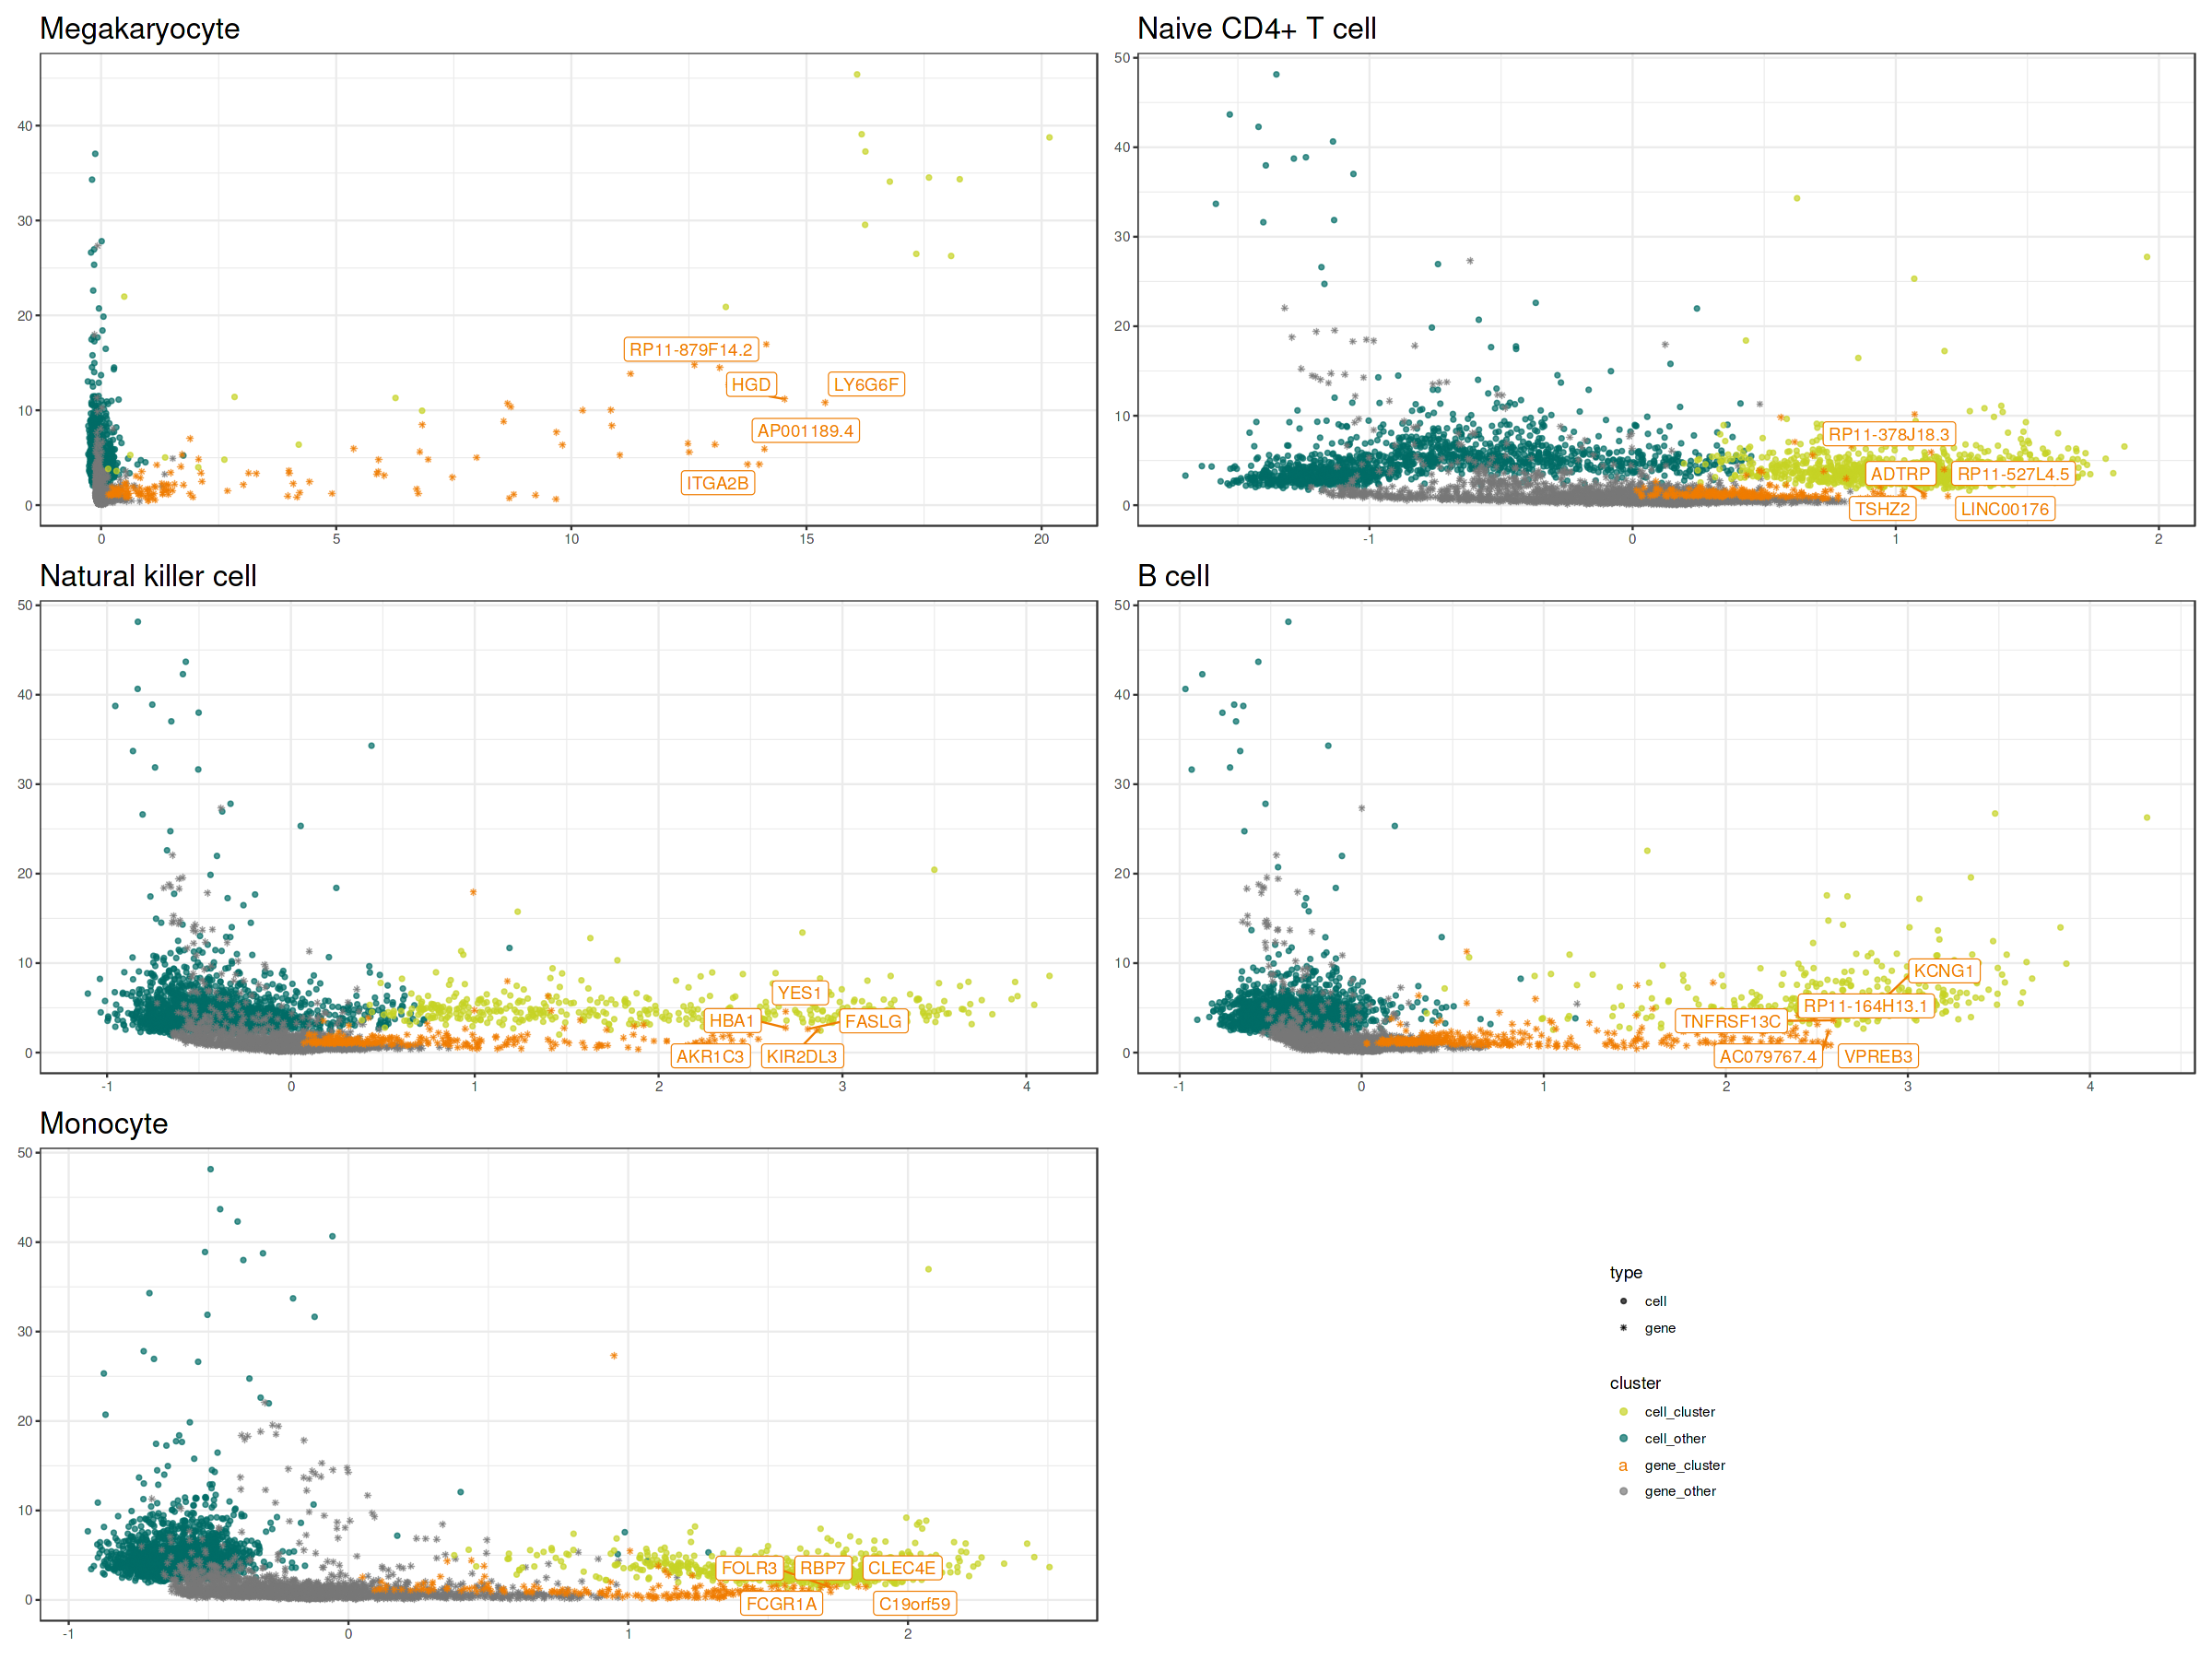

In [10]:
sce_corr <- sce[(!rownames(sce) %in% top_genes), (!colnames(sce) %in% top_cells)]

ca_corr <- cacomp(
    obj = as.matrix(logcounts(sce_corr)),
    princ_coords = 3,
    dims = 30,
    top = nrow(sce_corr),
    residuals = "pearson",
    python = TRUE,
    clip = TRUE
)

set.seed(2358)
cak_corr <- dirclust_splitmerge(
    caobj = ca_corr,
    k = 12,
    cutoff = NULL,
    method = "random",
    apl_quant = 0.99,
    counts = NULL,
    min_cells = 30,
    reps = 5,
    make_plots = FALSE,
    apl_cutoff_reps = 100,
    qcutoff = 0.6
)

cak_corr <- annotate_biclustering(
    obj = cak_corr,
    universe = rownames(sce_corr),
    org = "hs"
)

sce_corr$cadir_corr <- cak_corr@cell_clusters

cak_corr <- rank_genes(cadir = cak_corr, caobj = ca_corr)

pc_corr <- plot_clusters(
  cak_corr,
  ca_corr,
  show_genes = TRUE,
  label_genes = TRUE,
  axis = TRUE,
  ggncol = 2,
  ggnrow = 3,
  title_prefix = "",
  gsub_title = "_",
  text_size = 19,
  return_list = TRUE,
  legend_pos = "right"
)
pc_corr <- wrap_plots(pc_corr, ncol = 2, nrow = 3) +
  guide_area() +
  plot_layout(guides = "collect")

cak_corr
pc_corr

ggsave(
  plot = pc_corr,
  file = file.path(imgdir, "apl_clusters_corrected.pdf"),
  device = cairo_pdf,
  width = 3000,
  height = 2500,
  units = "px"
)

Sankey plot showing to which clusters the remaining cells from cluster 5 are being clustered.

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`summarise()` has grouped output by 'Biclusters'. You can override using the `.groups` argument.


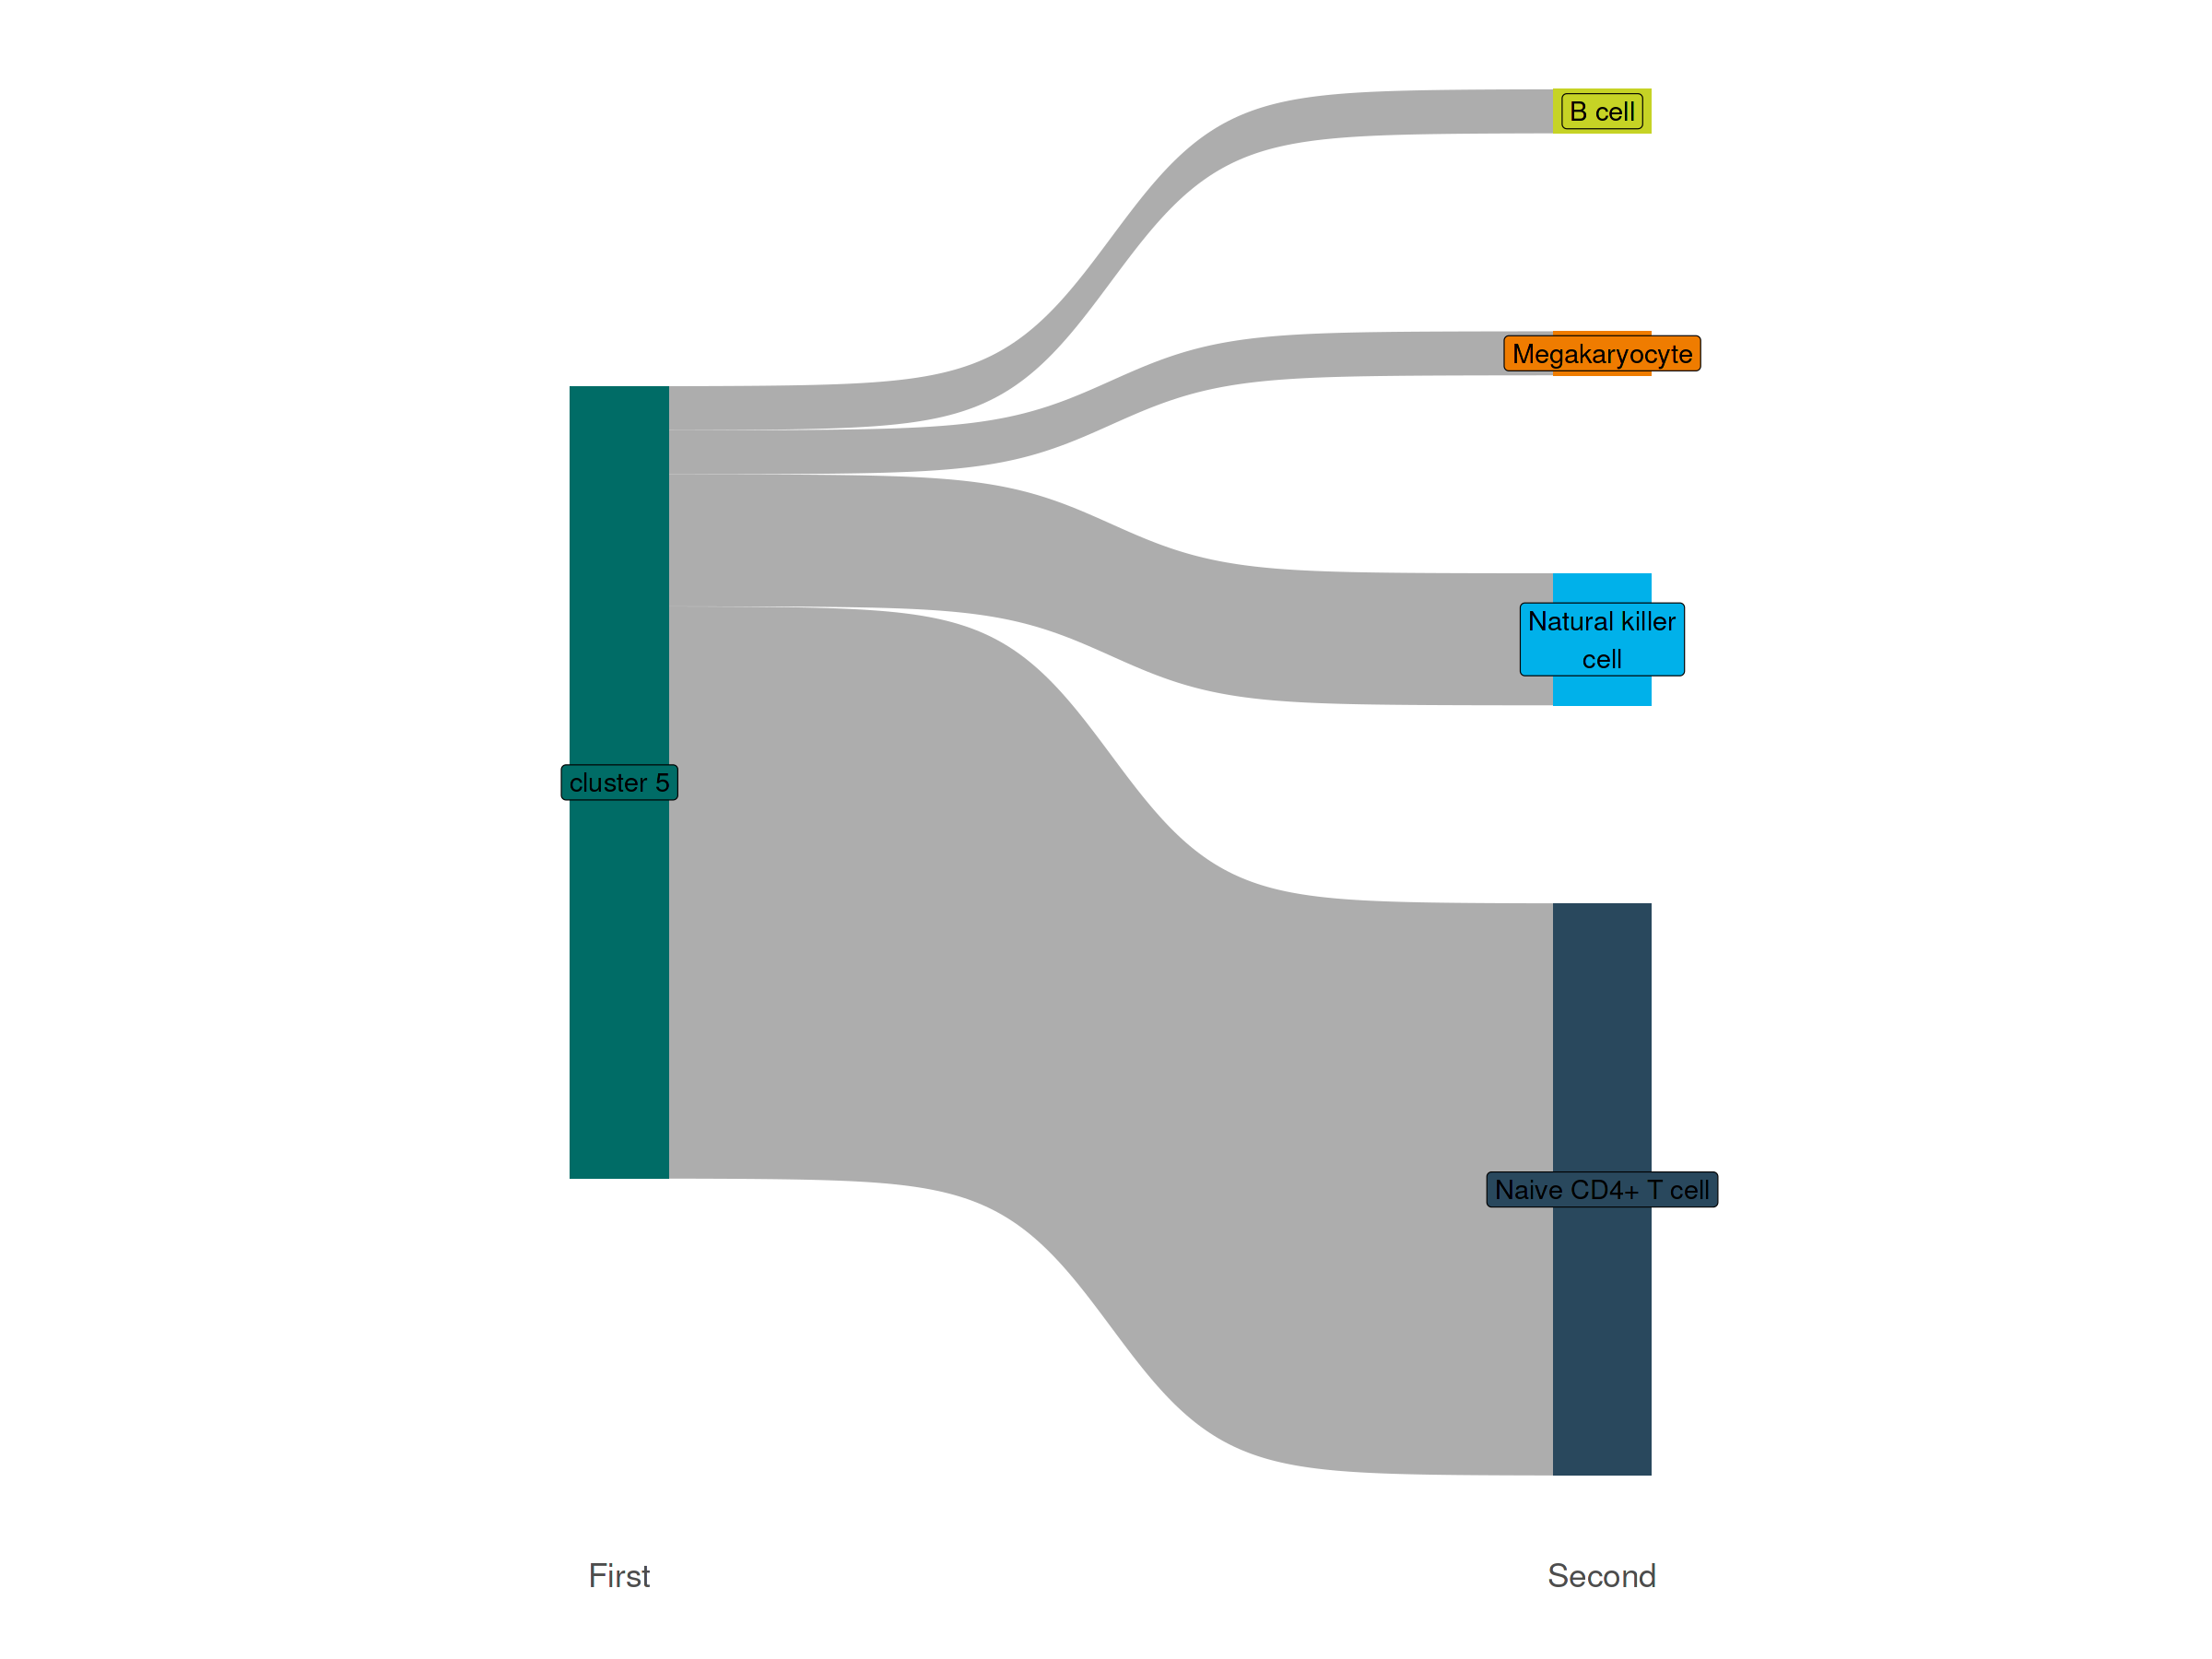

In [11]:
sce_corr$cadir2 <- cak_corr@cell_clusters
sce_sank <- sce_corr[,sce_corr$cadir == "cluster_5"]
cadir_cls <- unique(as.character(sce_sank$cadir))

data <- colData(sce_sank) %>%
        as.data.frame() %>%
        rename('First' = "cadir",
               'Second' = "cadir2")

df <- data %>%
    make_long(First, Second)

info  <-  data.frame(Biclusters = as.factor(data$First),
                     Truth = as.character(data$Second)) %>%
                as_tibble() %>%
                group_by(Biclusters, Truth) %>%
                summarise(n = n()) %>%
                group_by(Truth) %>%
                mutate(Partition = n/sum(n)) %>%
                ungroup() %>%
                as.data.frame() %>%
                group_by(Truth) %>%
                filter(Partition == max(Partition) ) %>%
                dplyr::select(Biclusters, Truth) %>%
                distinct(Biclusters, .keep_all = TRUE)


pal <- mpimg_pal()

cols <- pal(length(cadir_cls))
names(cols) <- cadir_cls

info <- left_join(data.frame("Biclusters" = names(cols), "col" = cols), info, by = "Biclusters")
info$col <- pal(nrow(info) + 1)[2:(nrow(info)+1)]

cols <- c(cols, info$col)

names(cols) <- c(as.character(cadir_cls), info$Truth)


order <- c(
  "cluster_5",
  "Naive_CD4+_T_cell",
  "Natural_killer_cell",
  "Megakaryocyte",
  "B_cell"
)

df$node <- gsub("_", " ", df$node)
df$next_node <- gsub("_", " ", df$next_node)
names(cols) <- gsub("_", " ", names(cols))
order <- gsub("_", " ", order)


wrap <- 17
df$node <- factor(stringr::str_wrap(df$node, wrap), levels = stringr::str_wrap(order, wrap))
df$next_node <- factor(stringr::str_wrap(df$next_node, wrap), levels = stringr::str_wrap(order, wrap))

names(cols) <- stringr::str_wrap(names(cols), wrap)


sank <- ggplot(df, aes(x = x,
               next_x = next_x,
               node = node,
               next_node = next_node,
               fill = node,
               label = as.character(node))) +
  geom_sankey(flow.alpha = 0.6, flow.fill = c("#777777") ) +
  geom_sankey_label(size = 6) +
  labs(x = "") +
  scale_fill_manual(values = cols) +
  theme_sankey(base_size = 26) +
  theme(
    legend.position = "none"
  )

sank

ggsave(plot = sank,
       filename = file.path(imgdir, "sankey_plot_cluster_5.pdf"),
  device = cairo_pdf,
       width = 2700,
       height = 2000,
       units = "px")

### Platelet cells

In [12]:
cak_corr_mod <- cak_corr

goa_res <- CAbiNet::per_cluster_goa(
  cabic = cak_corr_mod,
  universe = rownames(sce_corr),
  set = "CellMarker",
  org = "hs",
  min_size = 10,
  max_size = 500
)
head(goa_res$Megakaryocyte)

,gene_set,pval,padj,GeneRatio,BgRatio,ngois_in_set,ngenes_in_set,ngois,ngenes_in_sets
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<int>,<int>
49,Megakaryocyte,1.641001e-10,1.476901e-08,11/94,22/2272,11,22,94,2272
48,Mast_cell,9.134242e-05,2.740273e-03,8/94,37/2272,8,37,94,2272
78,Platelet,6.860314e-05,2.740273e-03,5/94,12/2272,5,12,94,2272
57,Mitotic_fetal_germ_cell,6.778636e-04,1.525193e-02,16/94,161/2272,16,161,94,2272
79,Progenitor_cell,4.265536e-03,7.677964e-02,5/94,27/2272,5,27,94,2272
33,Gonadal_mitotic_phase_fetal_germ_cell,6.611994e-03,9.917991e-02,7/94,55/2272,7,55,94,2272


Top 5 most highly significant gene sets for cluster "Megakaryocyte":

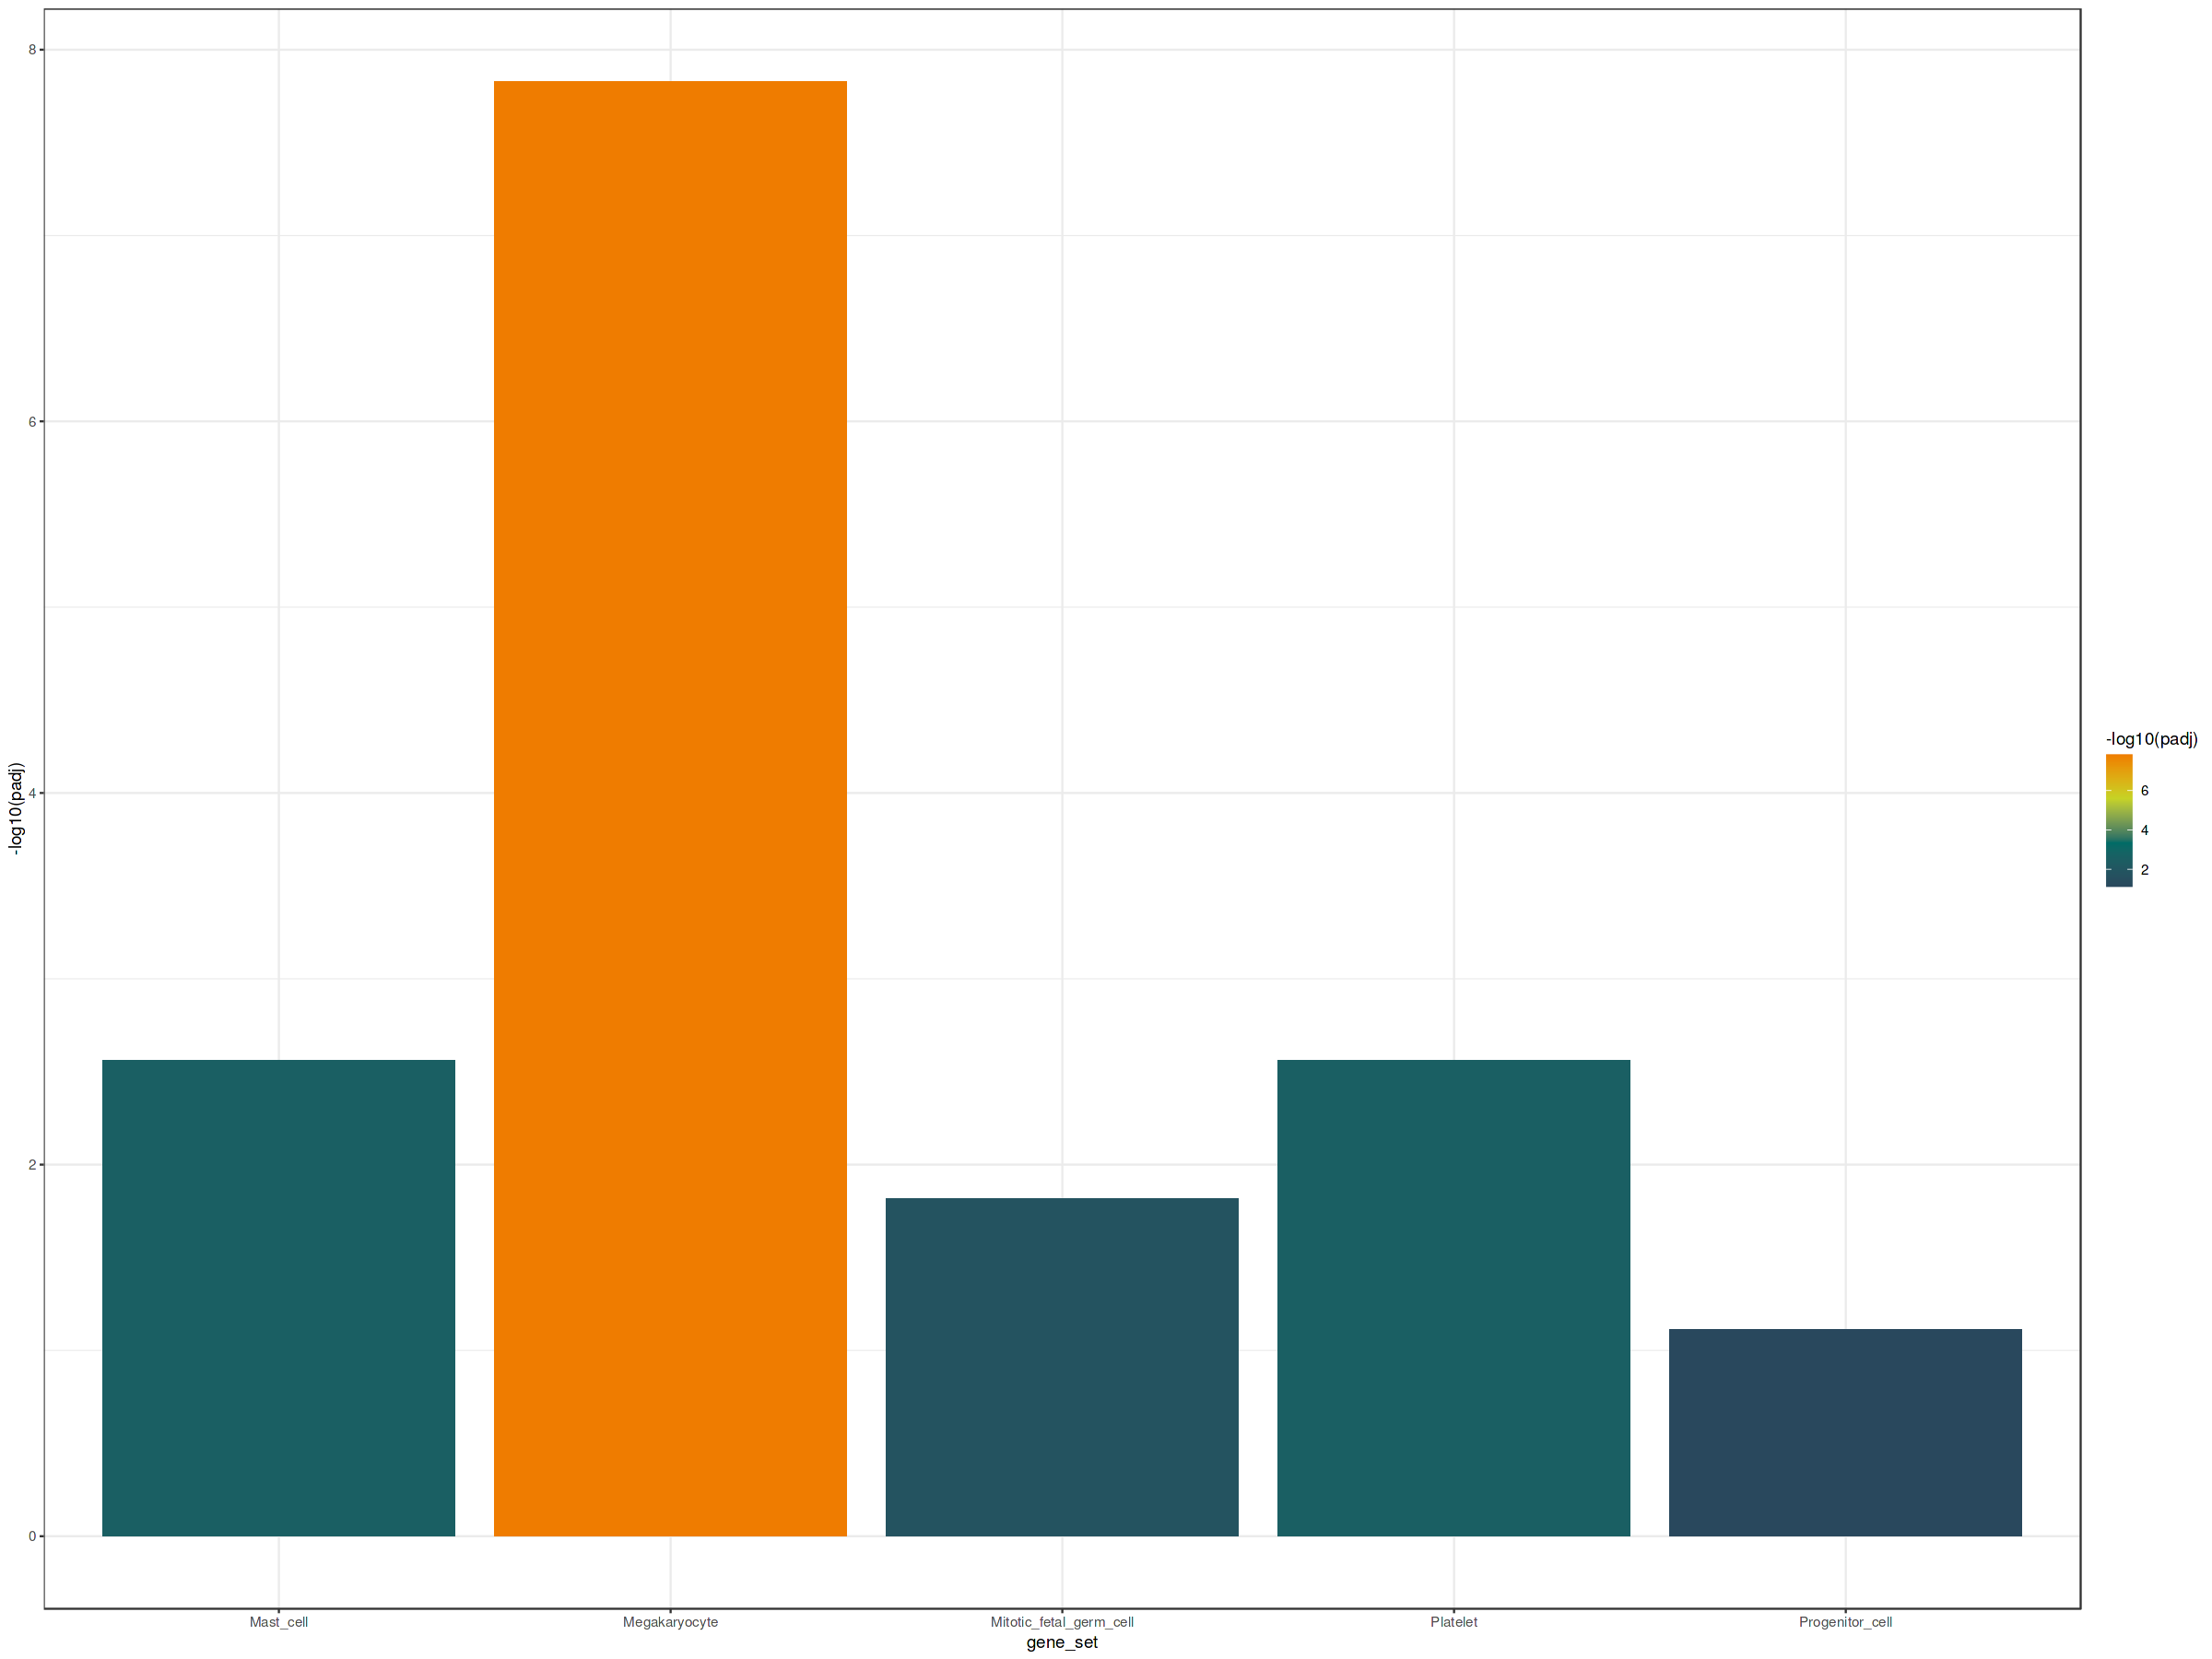

In [13]:
cl_goa <- goa_res$Megakaryocyte

ggplot(cl_goa[1:5, ], aes(x = gene_set, y = -log10(padj), fill = -log10(padj))) +
  geom_col() +
  scale_fill_gradientn(
    colours = c("#29485d", "#006c66", "#c6d325", "#ef7c00"),
  ) + 
  theme_bw()

Gene Set enrichment over all corrected clusters:

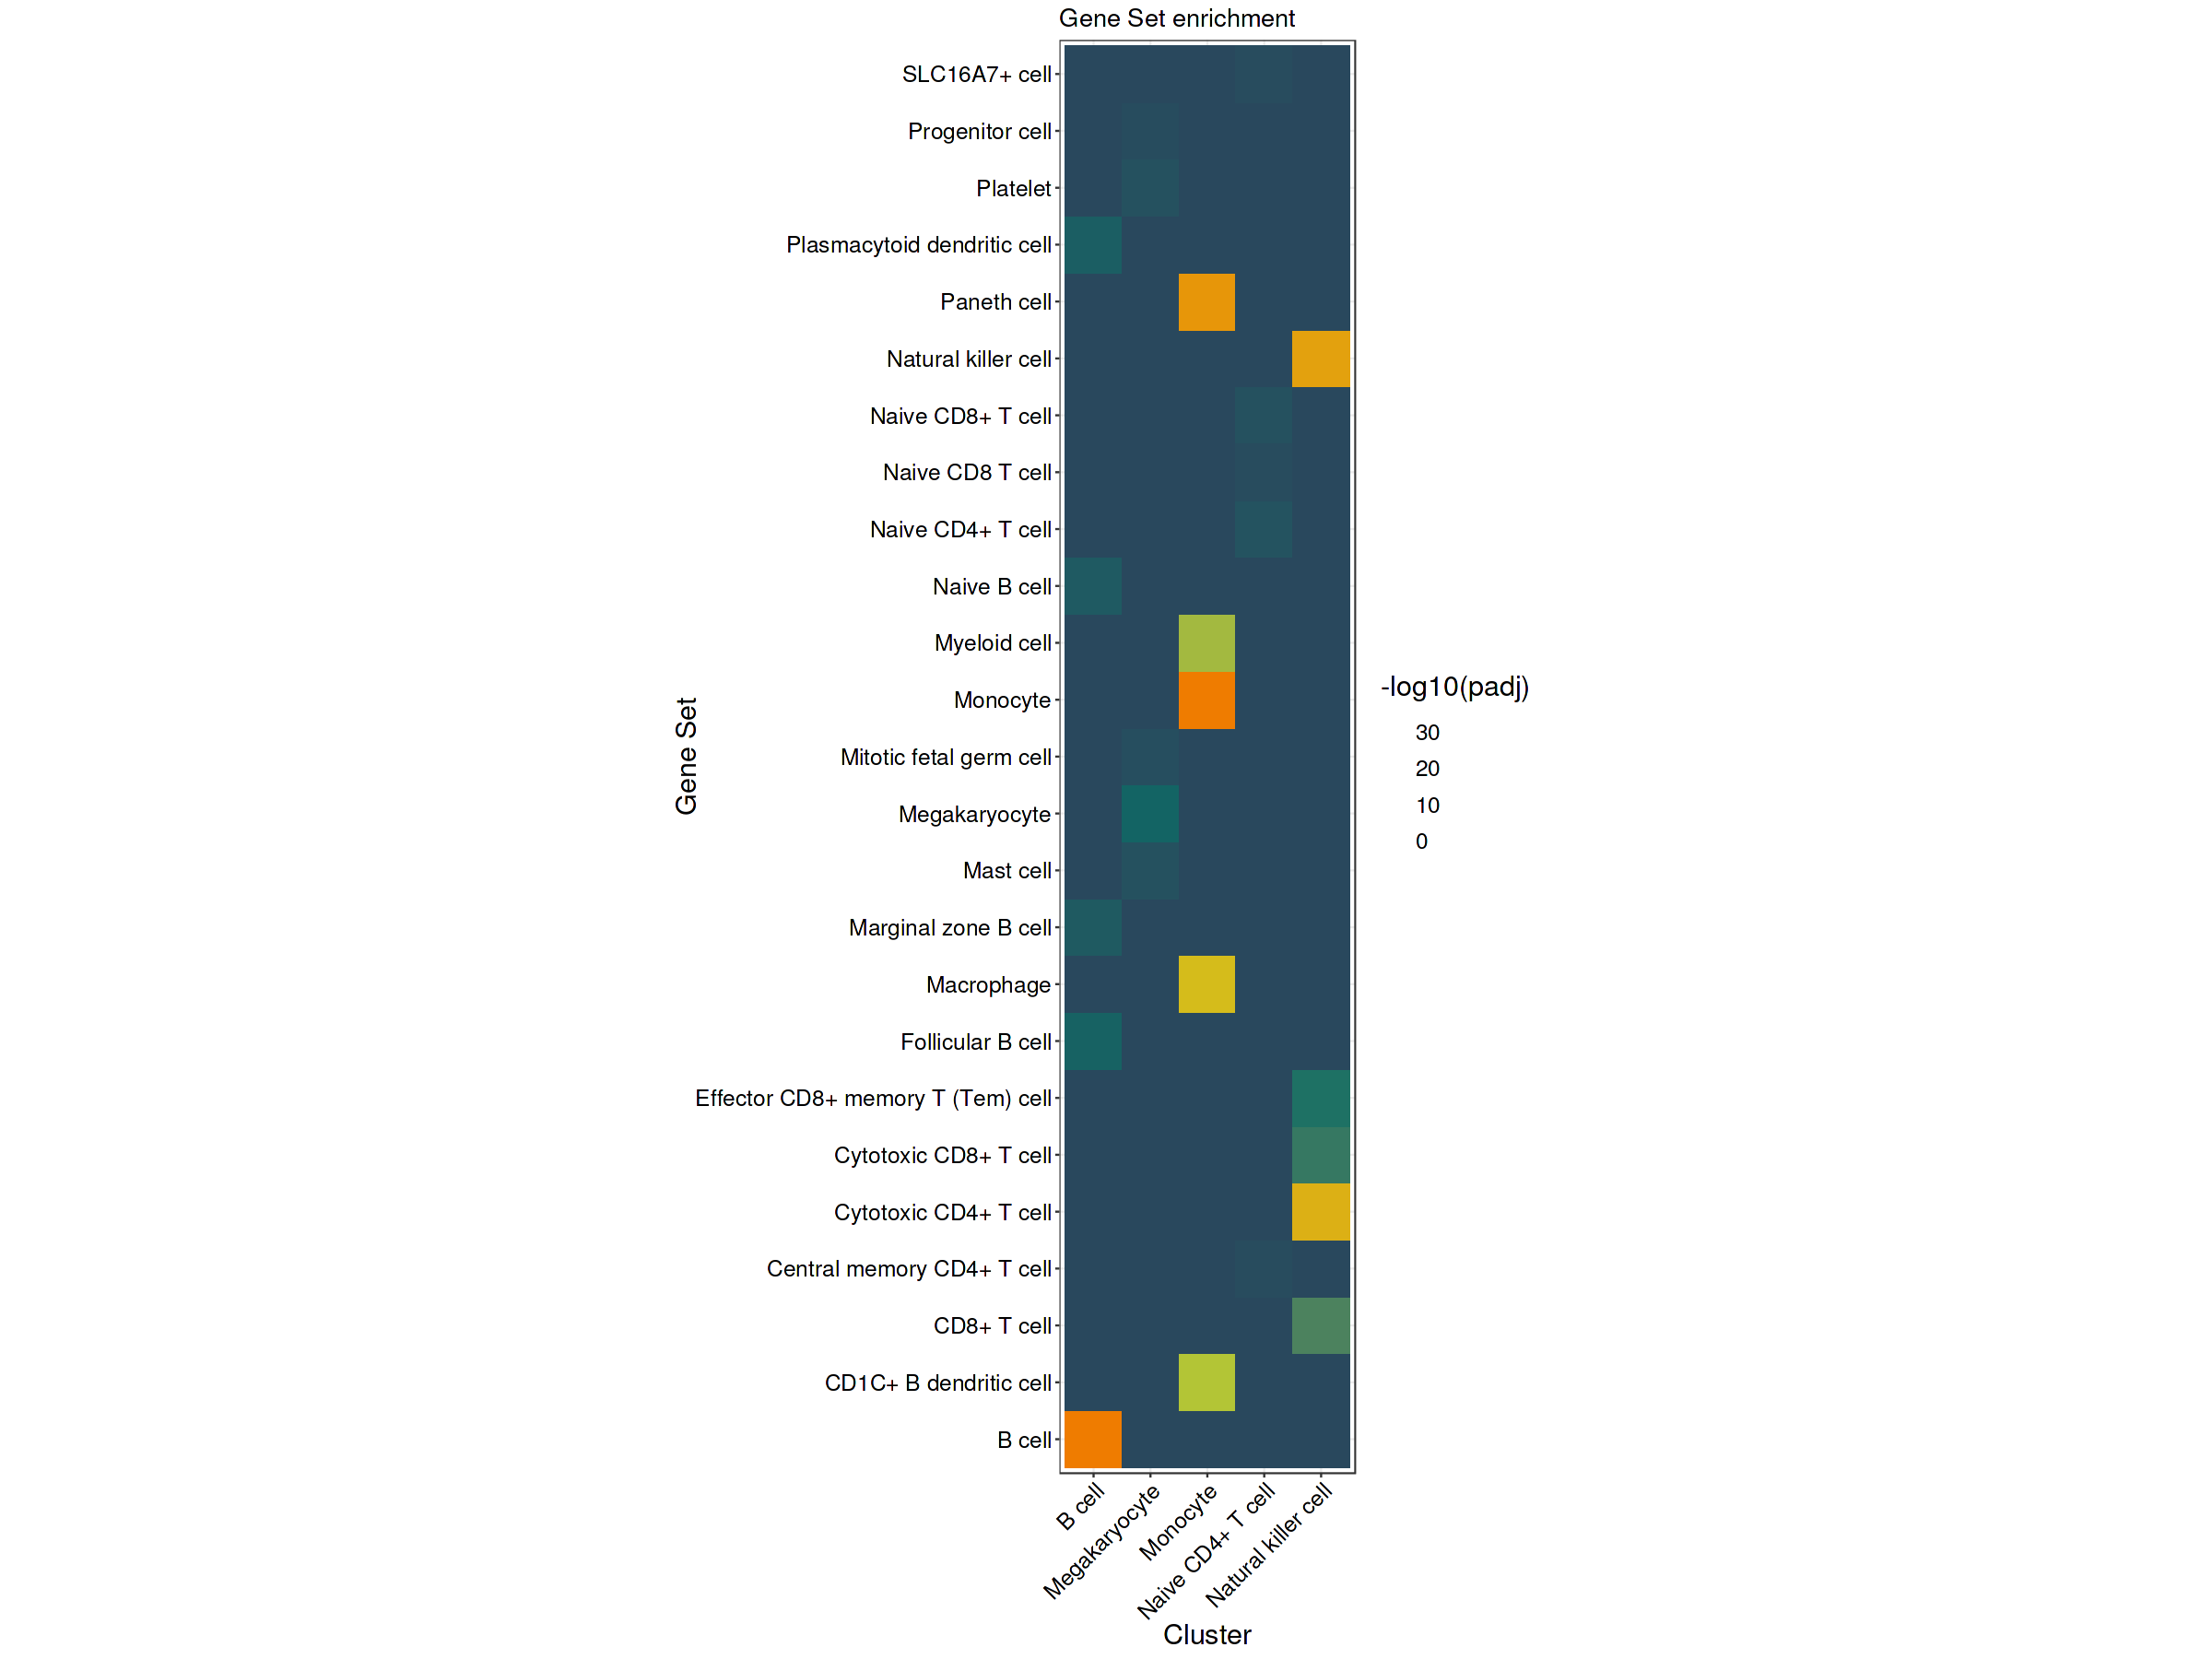

In [14]:
nclust <- length(goa_res)

goa_mat <- lapply(goa_res, function(x, nc = nclust) {
  subs <- min(nrow(x), nc)
  x[seq_len(subs), ]
})

goa_mat <- dplyr::bind_rows(goa_mat, .id = "cluster")

gr <- goa_mat[,c("cluster", "gene_set", "padj")]
gr <- complete(gr, cluster, gene_set, fill = list(padj = 1))
gr$gene_set <- gsub("_", " ", gr$gene_set)
gr$cluster <- gsub("_", " ", gr$cluster)

p_gs_enr <- ggplot(gr, aes(x = cluster, y = gene_set, fill = -log10(padj))) +
  geom_tile() +
  scale_fill_gradientn(
    colours = c("#29485d", "#006c66", "#c6d325", "#ef7c00"),
    limits = c(0, 30),
    # limits = c(0, quantile(-log10(gr$padj), 0.99)),
    oob = scales::squish,
    guide = "colourbar_custom"
  ) + 
  coord_fixed() +
  theme_bw() +
  labs(x = "Cluster", y = "Gene Set", title = "Gene Set enrichment") +
  theme(
  axis.text.x = element_text(angle = 45, hjust = 1, color = "black"),
  axis.text.y = element_text(color = "black"),
    text = element_text(size = 18),
    plot.title = element_text(size = 16, face = "plain"))  #"bold"

p_gs_enr

ggsave(
  plot = p_gs_enr,
  file = file.path(imgdir, "gene_set_enr_hm.pdf"),
  width = 2000,
  height = 3000,
  units = "px"
)

## Split & Merge plot

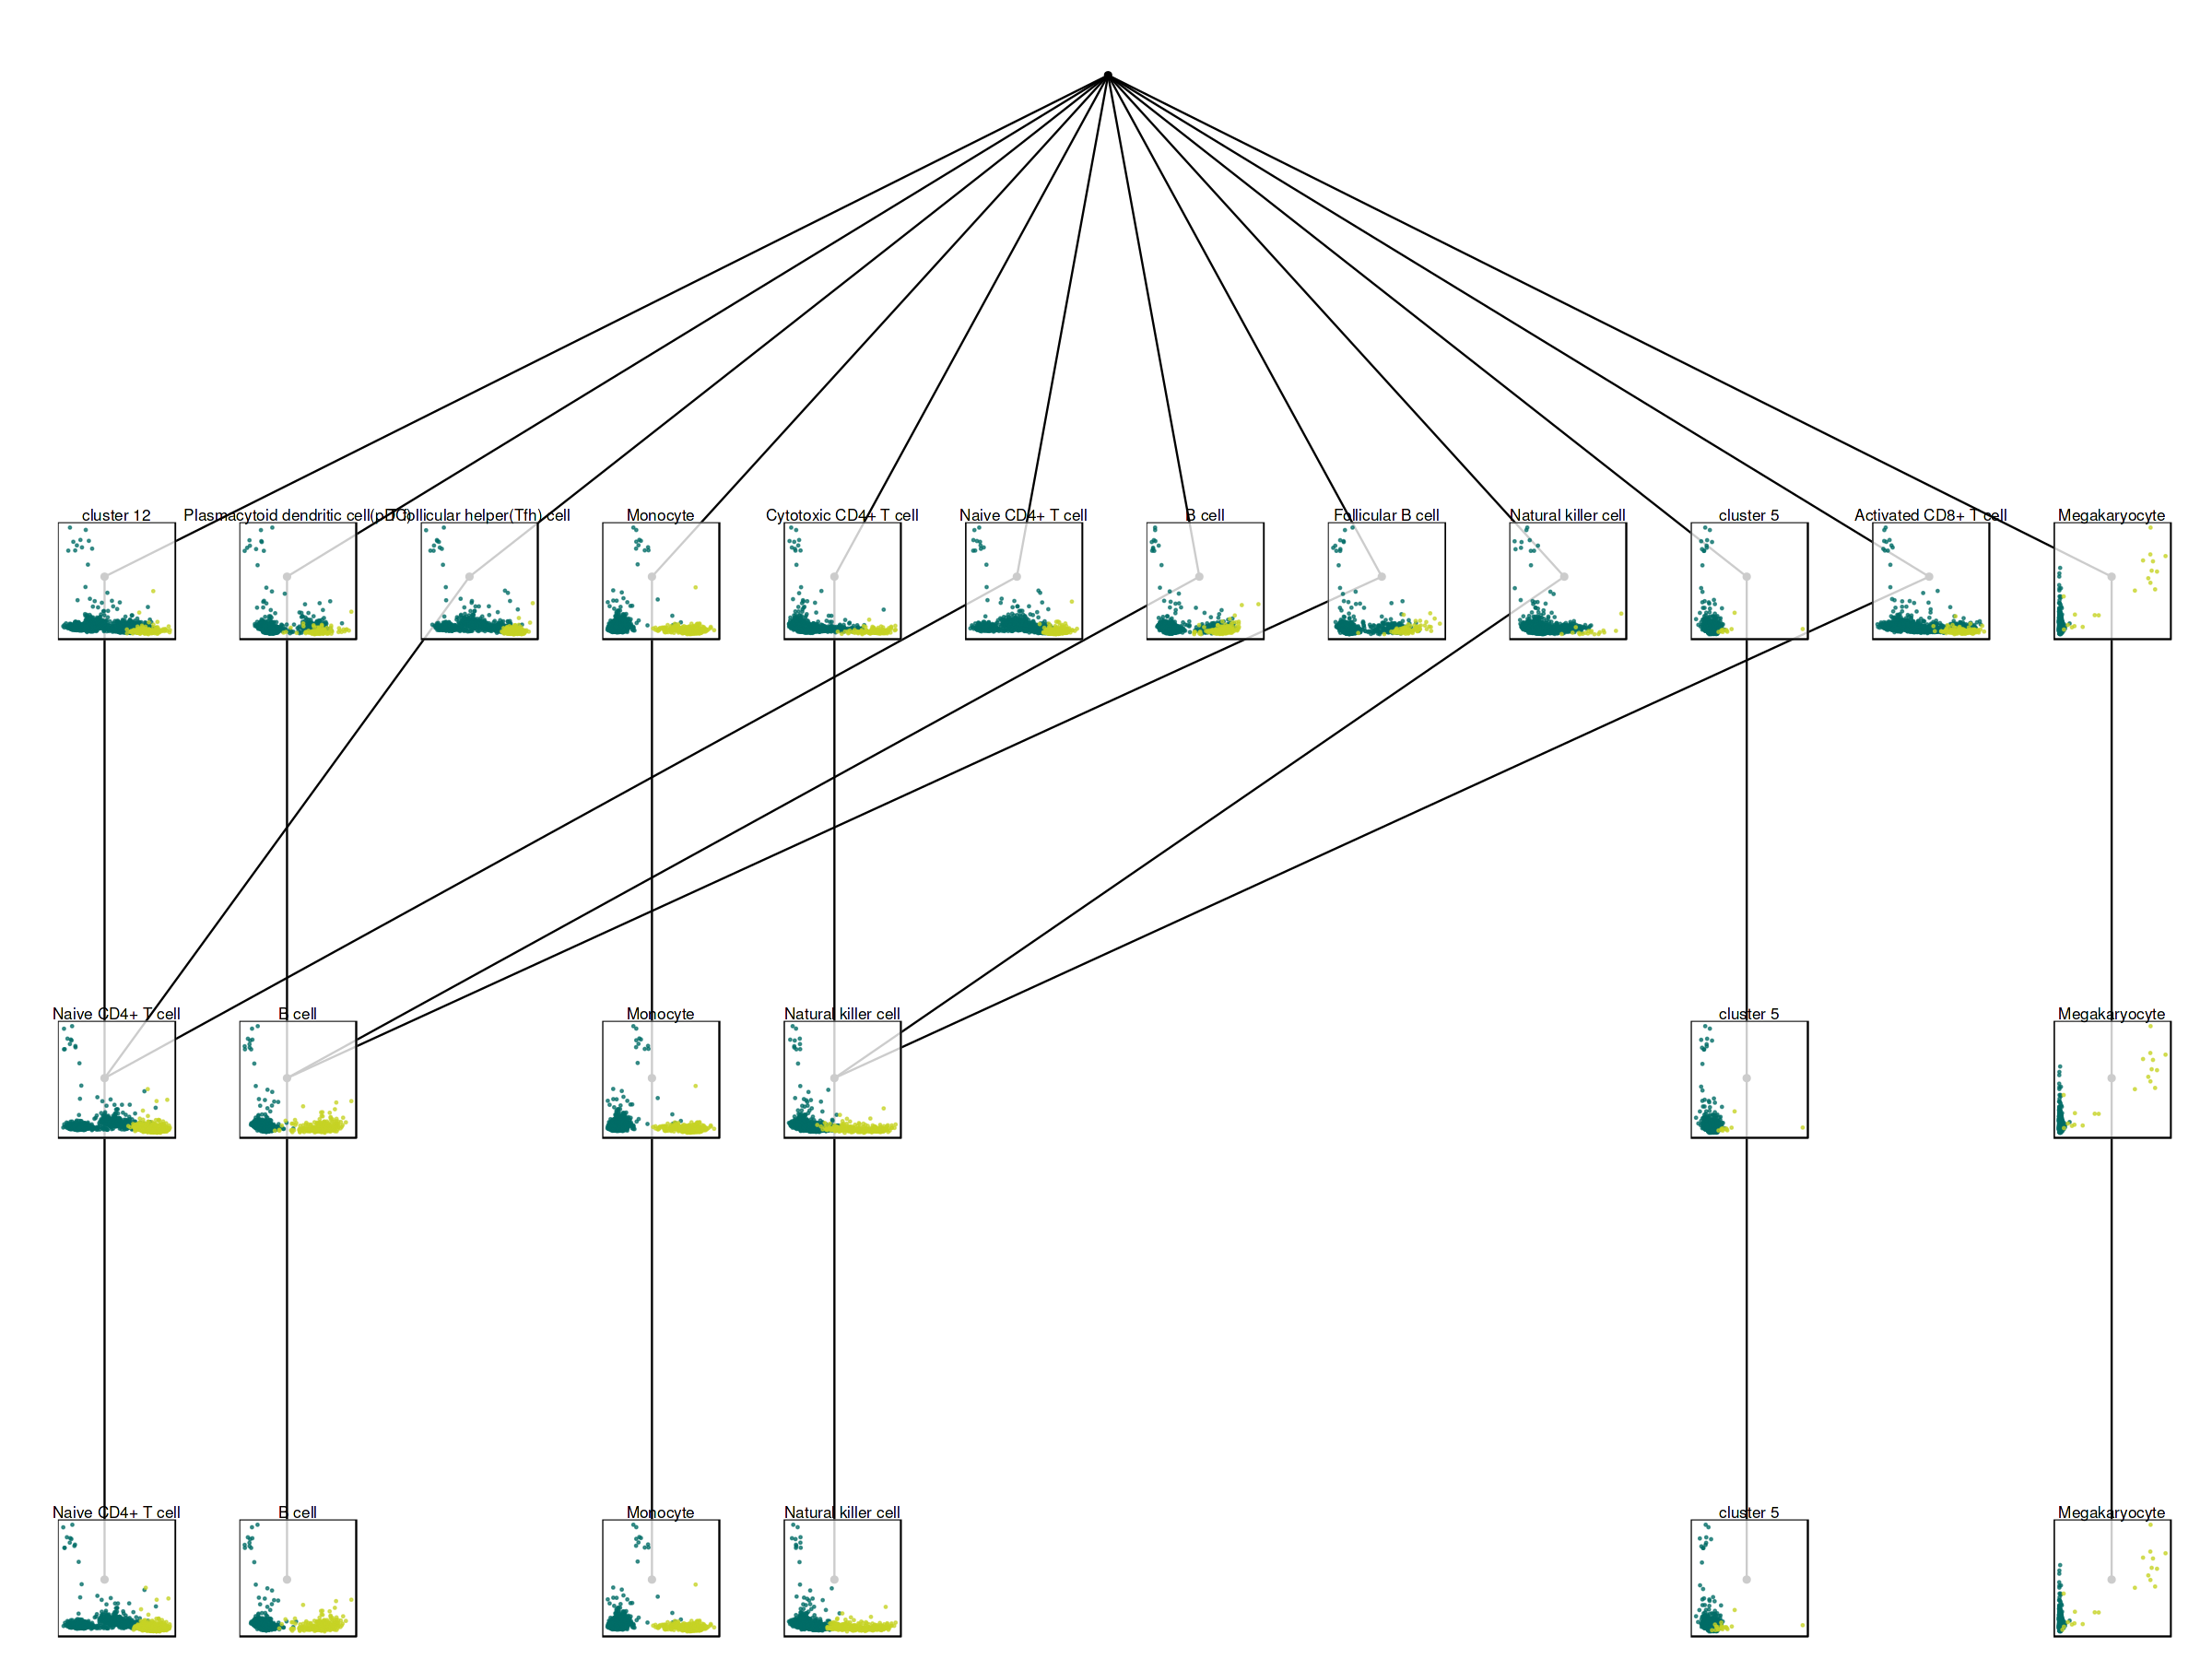

In [15]:
sm <- sm_plot(
  cadir = cak,
  caobj = ca,
  rm_redund = TRUE,
  keep_end = TRUE,
  highlight_cluster = TRUE,
  show_genes = F,
  annotate_clusters = TRUE,
  org = "hs"
)
sm

ggsave(plot = sm,
  file = file.path(imgdir, "split_merge_plot.pdf"),
  width = 3000,
  height = 1800,
  units = "px")

## Annotation - Sankey

Warning message:
“attributes are not identical across measure variables; they will be dropped”
`summarise()` has grouped output by 'Biclusters'. You can override using the `.groups` argument.


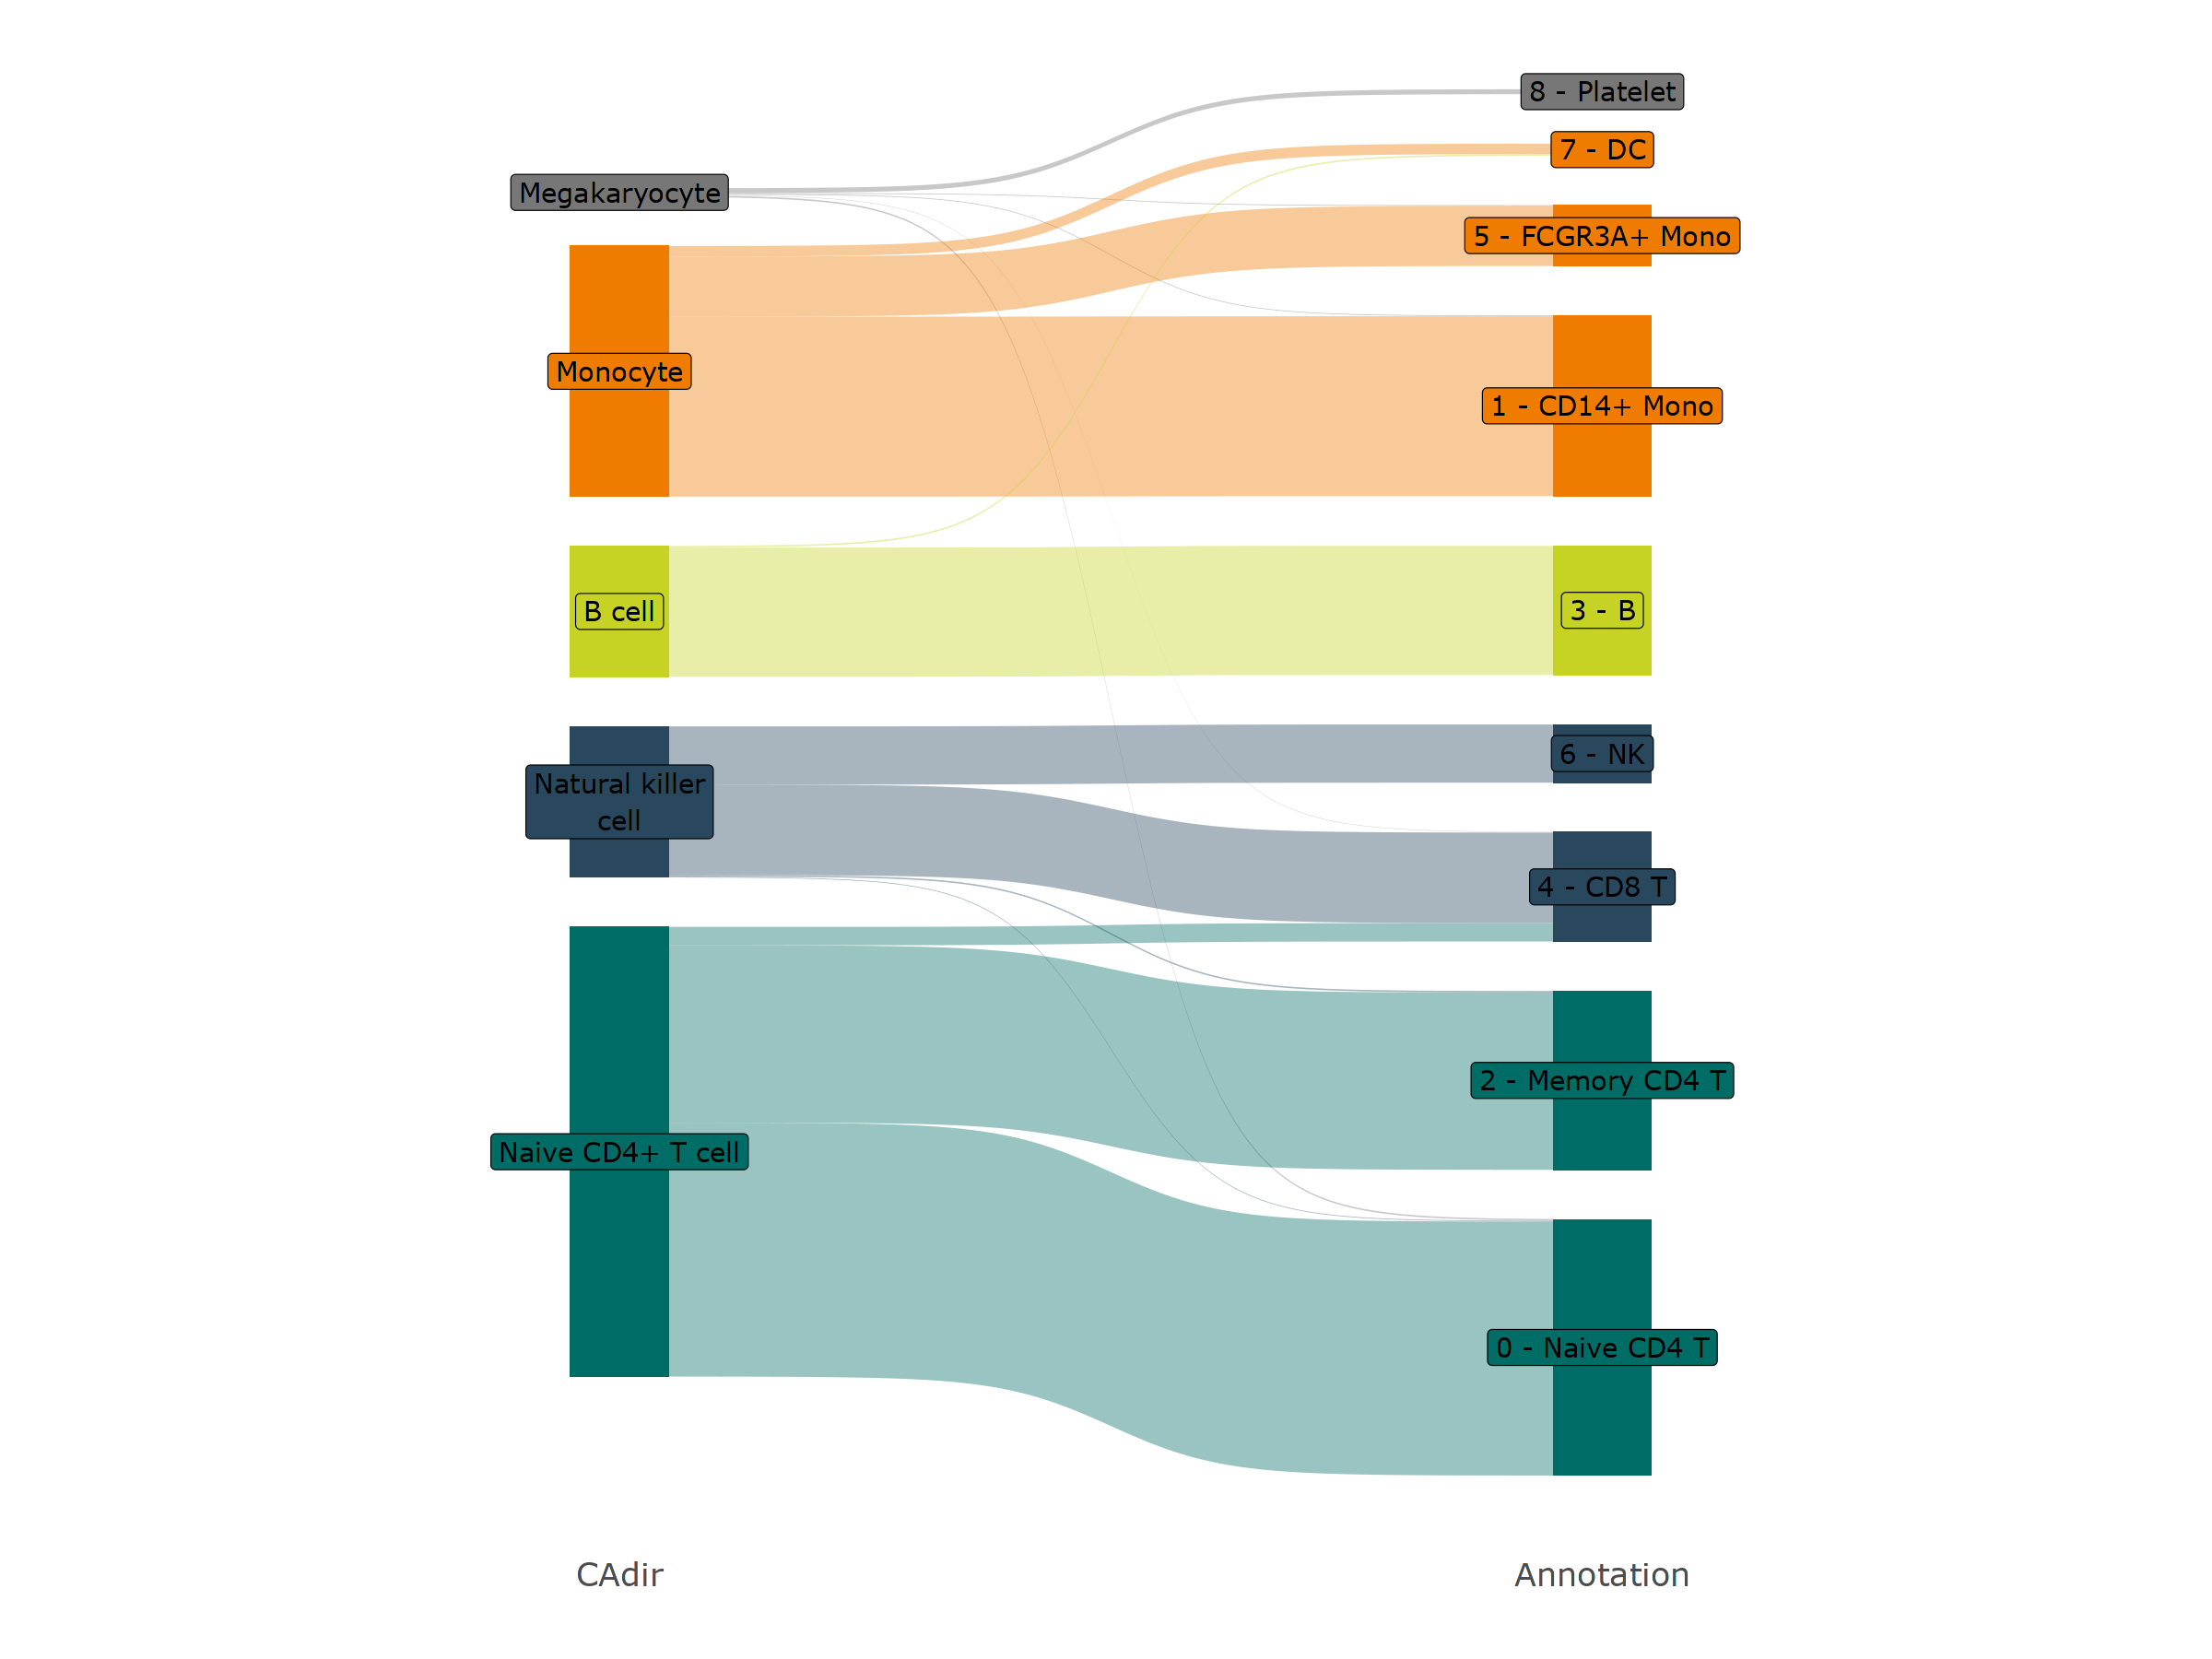

In [16]:
library(ggsankey)
sce_sank <- sce_corr

data <- colData(sce_sank) %>%
        as.data.frame() %>%
        rename('CAdir' = "cadir_corr",
               'Annotation' = "cell_type")

df <- data %>%
    make_long(CAdir, Annotation)

info  <-  data.frame(Biclusters = as.factor(data$CAdir),
                     Truth = as.character(data$Annotation)) %>%
                as_tibble() %>%
                group_by(Biclusters, Truth) %>%
                summarise(n = n()) %>%
                group_by(Truth) %>%
                mutate(Partition = n/sum(n)) %>%
                ungroup() %>%
                as.data.frame() %>%
                group_by(Truth) %>%
                filter(Partition == max(Partition) ) %>%
                dplyr::select(Biclusters, Truth) %>%
                distinct(Biclusters, .keep_all = TRUE)


pal <- mpi_extend_pal()

cols <- pal(length(unique(sce_sank$cadir)))
names(cols) <- unique(sce_sank$cadir)

info <- left_join(data.frame("Biclusters" = names(cols), "col" = cols), info, by = "Biclusters")

cols <- c(cols, info$col)

names(cols) <- c(as.character(unique(sce_sank$cadir)), info$Truth)

order <- c(
  "Naive_CD4+_T_cell",
  "Natural_killer_cell",
  "B_cell",
  "Monocyte",
  "Megakaryocyte",

  "0 - Naive CD4 T",
  "2 - Memory CD4 T",
  "4 - CD8 T",
  "6 - NK",
  "3 - B",
  "1 - CD14+ Mono",
  "5 - FCGR3A+ Mono",
  "7 - DC",
  "8 - Platelet"
)

df$node <- gsub("_", " ", df$node)
df$next_node <- gsub("_", " ", df$next_node)
names(cols) <- gsub("_", " ", names(cols))
order <- gsub("_", " ", order)

wrap <- 17
df$node <- factor(stringr::str_wrap(df$node, wrap), levels = stringr::str_wrap(order, wrap))
df$next_node <- factor(stringr::str_wrap(df$next_node, wrap), levels = stringr::str_wrap(order, wrap))

names(cols) <- stringr::str_wrap(names(cols), wrap)

sank <- ggplot(df, aes(x = x,
               next_x = next_x,
               node = node,
               next_node = next_node,
               fill = node,
               label = as.character(node))) +
  geom_sankey(
    flow.alpha = 0.4,
  ) +
  geom_sankey_label(size = 6) +
  labs(x = "") +
  scale_fill_manual(values = cols) +
  theme_sankey(base_size = 26, base_family = "sans") +
  theme(
    legend.position = "none"
  )

sank

ggsave(plot = sank,
       filename = file.path(imgdir, "sankey_plot_corr_clustering.pdf"),
       width = 2700,
       height = 3200,
       device = cairo_pdf,
       units = "px")

ggsave(plot = sank,
       filename = file.path(imgdir, "sankey_plot_corr_clustering.png"),
       width = 2700,
       height = 3200,
       units = "px")

# sessionInfo

In [17]:
sessionInfo()

R version 4.4.0 (2024-04-24)
Platform: x86_64-pc-linux-gnu
Running under: MarIuX64 2.0 GNU/Linux

Matrix products: default
BLAS:   /pkg/R-4.4.0-0/lib/R/lib/libRblas.so 
LAPACK: /usr/lib/liblapack.so.3.10.1

locale:
 [1] LC_CTYPE=en_US.UTF-8 LC_NUMERIC=C         LC_TIME=C           
 [4] LC_COLLATE=C         LC_MONETARY=C        LC_MESSAGES=C       
 [7] LC_PAPER=C           LC_NAME=C            LC_ADDRESS=C        
[10] LC_TELEPHONE=C       LC_MEASUREMENT=C     LC_IDENTIFICATION=C 

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] patchwork_1.2.0             gguidance_0.0.0.9001       
 [3] ggsankey_0.0.99999          scran_1.32.0               
 [5] scater_1.32.0               ggplot2_3.5.1              
 [7] scuttle_1.14.0              Seurat_5.0.1               
 [9] SeuratObject_5.0.2          sp_2.1-4                   
[11] TENxPBMC